## Homework #4. Exploratory Data Analysis
#### Author: `ANDRII VALENIA`
#### Intermediate result time spent on h/w (in minutes): `300`
#### Sentiment analysis time spent on h/w (in minutes): `200`
#### Topic categorization time spent on h/w (in minutes): `400`
#### User Feedback on ChatGPT Responses time spent on h/w (in minutes): `110`
#### Prompt Techniques time spent on h/w (in minutes): `70`
#### Total time spent on h/w (in minutes): `1080`

Data analysis would be performed on the [dataset](https://www.kaggle.com/datasets/noahpersaud/89k-chatgpt-conversations/data) containing information about chatgpt conversations.

In [ ]:
%pip install -r requirements.txt

### Loading data

In [2]:
import pandas as pd

dataset_path = 'data/chatlogs-v2.jsonl'

df = pd.read_json(dataset_path, lines=True)

In [11]:
df.head()

,post_number,system_message,conversation
0,[57],[],"[{'user': 'Anonymous', 'message': 'What is con..."
1,[53],[],"[{'user': 'Anonymous', 'message': 'write a poe..."
2,[56],[],"[{'user': 'Anonymous', 'message': 'What is con..."
3,[54],[],"[{'user': 'Anonymous', 'message': 'Can we use ..."
4,[51],[],"[{'user': 'Anonymous', 'message': 'como eu faç..."


Let's transform the data to a more convenient format where each row corresponds to a single conversation message.

In [18]:
rows = []
for _, row in df.iterrows():
    post_number = row['post_number']
    conversation = row['conversation']
    
    if isinstance(conversation, list):
        for message_order, message in enumerate(conversation):
            user = message['user']
            text = message['message']
            rows.append({
                'post_number': post_number[0], 
                'user': user, 
                'message': text,
                'message_order': message_order
            })

df_expanded = pd.DataFrame(rows)
df_expanded.head()

,post_number,user,message,message_order
0,57,Anonymous,What is contrastive loss?,0
1,57,Chat GPT,Contrastive loss is a type of loss function th...,1
2,57,Anonymous,Do we need labels for contrastive learning?,2
3,57,Chat GPT,"In contrastive learning, it is not necessary t...",3
4,57,Anonymous,"Right, but we still need to know the differenc...",4


### General conversation analysis

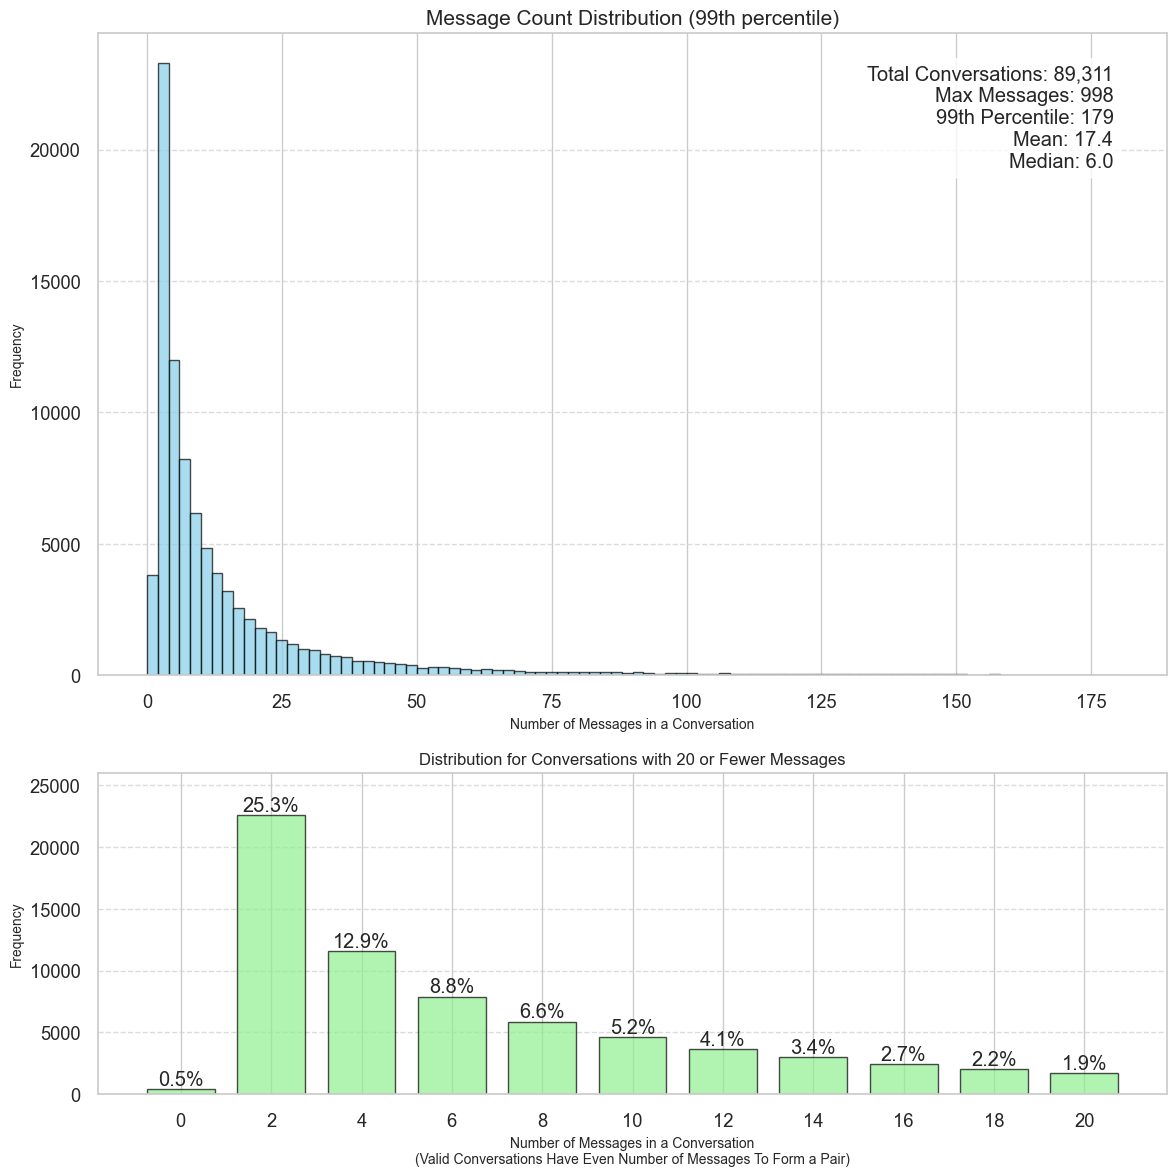

In [364]:
import matplotlib.pyplot as plt
import numpy as np

df['message_count'] = df['conversation'].apply(lambda x: len(x) if isinstance(x, list) else 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])

# First plot remains histogram
max_percentile = np.percentile(df['message_count'], 99)
bins = np.arange(0, max_percentile + 2, 2)

ax1.hist(df['message_count'][df['message_count'] <= max_percentile], 
         bins=bins, 
         color='skyblue', 
         edgecolor='black',
         alpha=0.7)

ax1.set_title('Message Count Distribution (99th percentile)', fontsize=15)
ax1.set_xlabel('Number of Messages in a Conversation', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

stats_text = f'Total Conversations: {len(df):,}\n'
stats_text += f'Max Messages: {df["message_count"].max():,}\n'
stats_text += f'99th Percentile: {max_percentile:.0f}\n'
stats_text += f'Mean: {df["message_count"].mean():.1f}\n'
stats_text += f'Median: {df["message_count"].median():.1f}'

ax1.text(0.95, 0.95, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

small_plot_size = 20
message_counts = range(0, small_plot_size + 1, 2)
counts = [len(df[df['message_count'] == count]) for count in message_counts]
total = len(df)

ax2.bar(message_counts, counts, 
        color='lightgreen', 
        edgecolor='black',
        alpha=0.7,
        width=1.5)

for count, value in zip(message_counts, counts):
    percentage = (value / total) * 100
    ax2.text(count, value, f'{percentage:.1f}%',
             ha='center', va='bottom')

ax2.set_ylim(0, max(counts) * 1.15)
ax2.set_title('Distribution for Conversations with 20 or Fewer Messages', fontsize=12)
ax2.set_xlabel('Number of Messages in a Conversation\n(Valid Conversations Have Even Number of Messages To Form a Pair)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

ax2.set_xticks(message_counts)
ax2.set_xticklabels(message_counts)

plt.tight_layout()
plt.show()

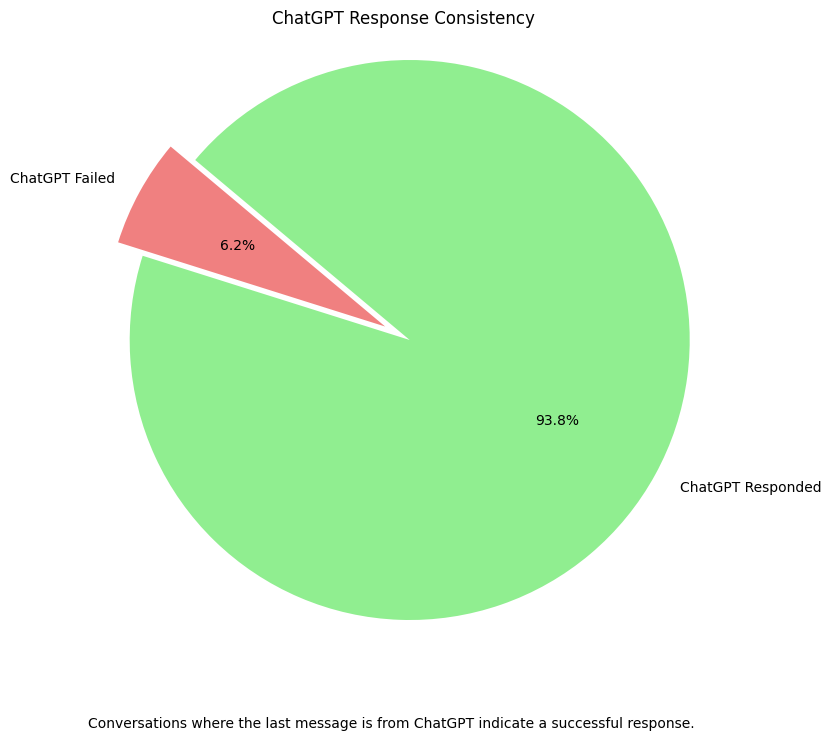

In [20]:
last_message_user = df_expanded.groupby('post_number').last()['user']
chatgpt_responded = last_message_user == 'Chat GPT'

chatgpt_responded_count = chatgpt_responded.sum()
chatgpt_failed_count = len(chatgpt_responded) - chatgpt_responded_count

labels = ['ChatGPT Failed', 'ChatGPT Responded']
sizes = [chatgpt_failed_count, chatgpt_responded_count]
colors = ['lightcoral', 'lightgreen']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=(0.1, 0))
plt.title('ChatGPT Response Consistency')
plt.figtext(0.5, 0.01, 'Conversations where the last message is from ChatGPT indicate a successful response.', ha='center', fontsize=10)
plt.axis('equal')
plt.show()

### Language analysis

Detect the language of the messages.

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect, LangDetectException
import pandas as pd
from pathlib import Path
from time import time
from IPython.display import display
import ipywidgets as widgets

def safe_language_detect(text) -> str:
    try:
        return detect(str(text))
    except LangDetectException:
        return 'unknown'

def process_batch(texts):
    return [safe_language_detect(text) for text in texts]

def create_batches(df, batch_size=100) -> list:
    return [df['message'].iloc[i:i + batch_size].tolist() 
            for i in range(0, len(df), batch_size)]

def detect_languages(df, batch_size=100, max_workers=12) -> list:
    batches = create_batches(df, batch_size)
    results = []
    total_batches = len(batches)
    
    progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=total_batches,
        description='Processing:',
        bar_style='info',
        orientation='horizontal'
    )
    
    status_text = widgets.HTML(value='Starting...')
    display(widgets.VBox([progress, status_text]))
    
    start_time = time()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]
        
        for idx, future in enumerate(as_completed(futures)):
            batch_results = future.result()
            results.extend(batch_results)
            
            # Update progress bar and status
            progress.value = idx + 1
            elapsed_time = time() - start_time
            est_total_time = elapsed_time / (idx + 1) * total_batches
            est_remaining = est_total_time - elapsed_time
            
            status_text.value = (
                f'Processed: {idx + 1}/{total_batches} batches | '
                f'Est. remaining: {est_remaining:.1f}s'
            )
    
    status_text.value = 'Processing completed!'
    return results

expanded_csv_path = 'data/expanded_chatlogs.csv'

if Path(expanded_csv_path).is_file():
    df_expanded = pd.read_csv(expanded_csv_path)
    print("Using existing CSV file.")
else:
    print("Detecting languages for each message...")
    df_expanded['language'] = detect_languages(df_expanded)
    df_expanded.to_csv(expanded_csv_path, index=False)

Detecting languages for each message...


Took 51 minutes to detect language of each message.

In [22]:
df_expanded.shape

(1549630, 5)

In [28]:
df_expanded.sample(10)

,post_number,user,message,message_order,language
197135,77712,Chat GPT,A mentalidade financeira é um dos aspectos mai...,71,ko
1167882,27698,Chat GPT,Revised Summary:,13,en
66309,86326,Chat GPT,Connotation refers to the emotional or cultura...,9,en
224408,76291,Anonymous,ahora hablemos de los factores economicos al t...,6,ru
706669,51141,Chat GPT,Voici le tableau mis à jour en intégrant les s...,73,en
814920,45890,Chat GPT,"Sure, I'm ready to follow along. Please go ahead.",21,en
523571,60479,Chat GPT,"To retrieve logs from CloudWatch in real-time,...",3,el
729264,49869,Anonymous,Consider everything that we have discussed in ...,32,zh-cn
1534072,1822,Anonymous,pokračuj,6,es
114611,83365,Anonymous,Can you manually get data into influxDB using ...,20,fi


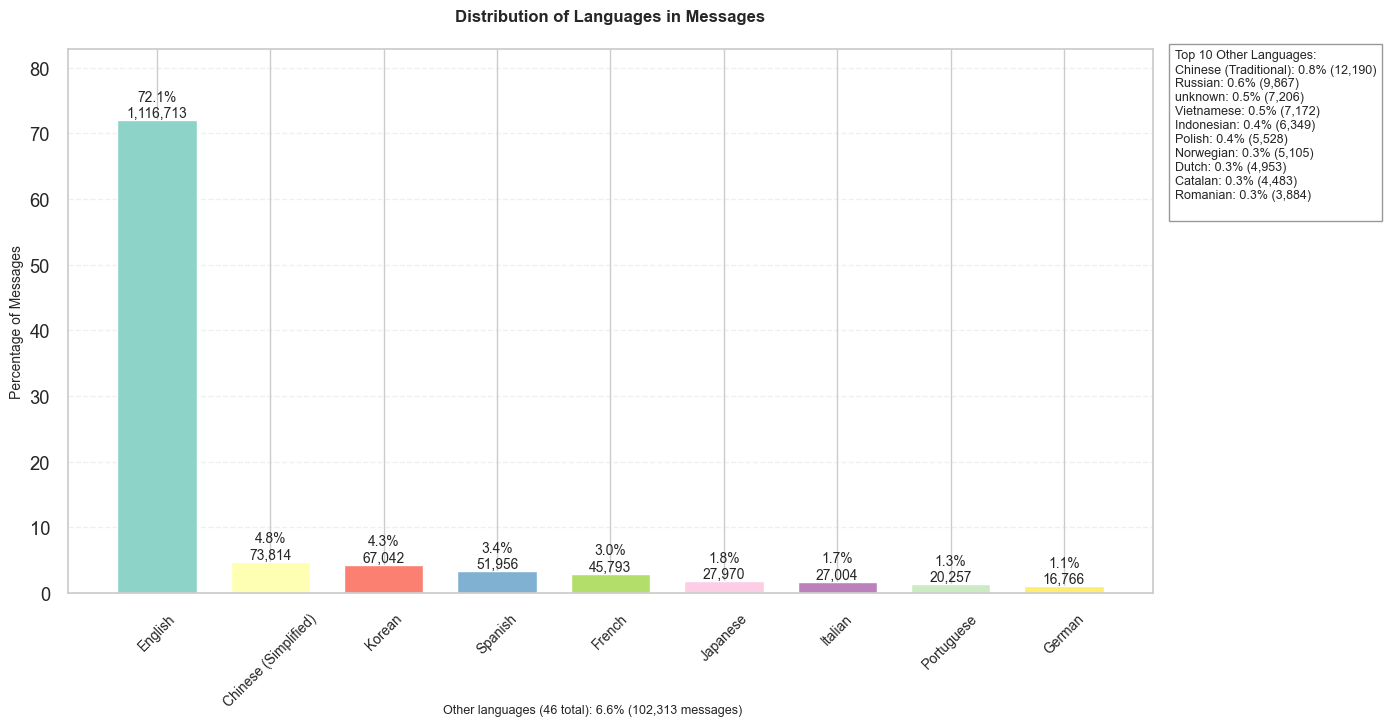

In [42]:
import pycountry

def get_country_name(code):
    if code == 'zh-cn':
        return 'Chinese (Simplified)'
    elif code == 'zh-tw':
        return 'Chinese (Traditional)'
    country_info = pycountry.languages.get(alpha_2=code)
    return country_info.name if country_info else code

def plot_language_distribution(df, threshold_percent=2):
    language_counts = df['language'].value_counts()
    total_messages = len(df)
    
    percentages = (language_counts / total_messages) * 100
    percentages_sorted = percentages.sort_values(ascending=False)
    main_languages = percentages_sorted[percentages_sorted >= threshold_percent]
    other_languages = percentages_sorted[percentages_sorted < threshold_percent]
    
    plt.figure(figsize=(14, 8))
    
    main_ax = plt.gca()
    main_ax.bar(range(len(main_languages)), 
                main_languages,
                color=plt.cm.Set3(np.linspace(0, 1, len(main_languages))),
                width=0.7)
    
    for i, v in enumerate(main_languages):
        count = int(v * total_messages / 100)
        main_ax.text(i, v, f'{v:.1f}%\n{count:,}', 
                    ha='center', va='bottom', fontsize=10)
    
    main_ax.set_xticks(range(len(main_languages)))
    main_ax.set_xticklabels([get_country_name(lang) for lang in main_languages.index], rotation=45, fontsize=10)
    main_ax.set_ylabel('Percentage of Messages', fontsize=10)
    main_ax.set_ylim(0, max(main_languages) * 1.15)
    
    main_ax.set_title('Distribution of Languages in Messages', 
                      pad=20, size=12, weight='bold')
    
    main_ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    other_pct = other_languages.sum()
    other_count = int(other_pct * total_messages / 100)
    
    top_10_text = "Top 10 Other Languages:\n"
    for lang, pct in other_languages[:10].items():
        count = int(pct * total_messages / 100)
        top_10_text += f"{get_country_name(lang)}: {pct:.1f}% ({count:,})\n"
    
    main_ax.text(1.02, 1.0, top_10_text,
                 transform=main_ax.transAxes,
                 bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
                 fontsize=9,
                 verticalalignment='top')
    
    summary_text = f'Other languages ({len(other_languages)} total): {other_pct:.1f}% ({other_count:,} messages)'
    plt.figtext(0.5, 0.05, summary_text, ha='center', fontsize=9)
    plt.subplots_adjust(bottom=0.2)
    plt.show()

plot_language_distribution(df_expanded, threshold_percent=1)

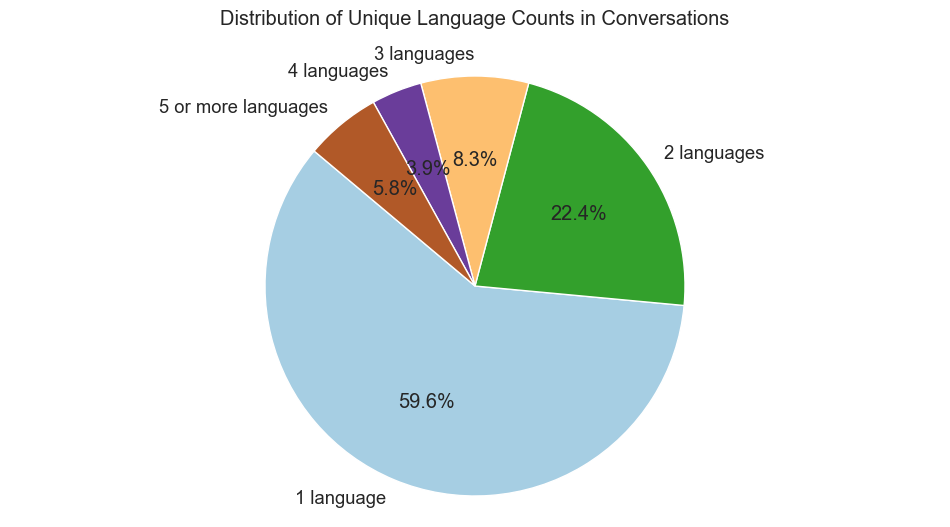

In [372]:
language_counts_per_conversation = df_expanded.groupby('post_number')['language'].nunique().reset_index()
language_counts_per_conversation.columns = ['post_number', 'unique_language_count']
language_counts_per_conversation['unique_language_count'] = language_counts_per_conversation['unique_language_count'].apply(lambda x: '5 or more' if x >= 5 else str(x))
language_count_distribution = language_counts_per_conversation['unique_language_count'].value_counts().sort_index()
labels = [f'{count} language{"s" if count != "1" else ""}' for count in language_count_distribution.index]

plt.figure(figsize=(12, 6))
plt.pie(language_count_distribution, 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=plt.cm.Paired(np.linspace(0, 1, len(language_count_distribution))),
    startangle=140)
plt.title('Distribution of Unique Language Counts in Conversations\n')
plt.axis('equal')
plt.show()


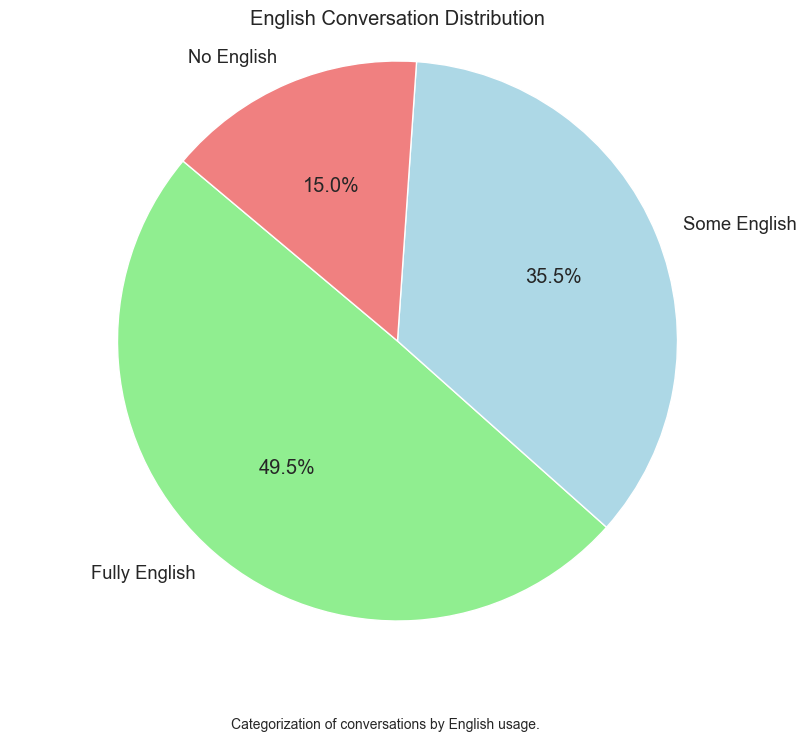

In [368]:
conversations = df_expanded.groupby('post_number')['language'].apply(list)

fully_english = sum(all(lang == 'en' for lang in convo) for convo in conversations)
some_english = sum(any(lang == 'en' for lang in convo) and not all(lang == 'en' for lang in convo) for convo in conversations)
no_english = sum(all(lang != 'en' for lang in convo) for convo in conversations)

labels = ['Fully English', 'Some English', 'No English']
sizes = [fully_english, some_english, no_english]
colors = ['lightgreen', 'lightblue', 'lightcoral']

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('English Conversation Distribution')
plt.figtext(0.5, 0.01, 'Categorization of conversations by English usage.', ha='center', fontsize=10)
plt.axis('equal')
plt.show()

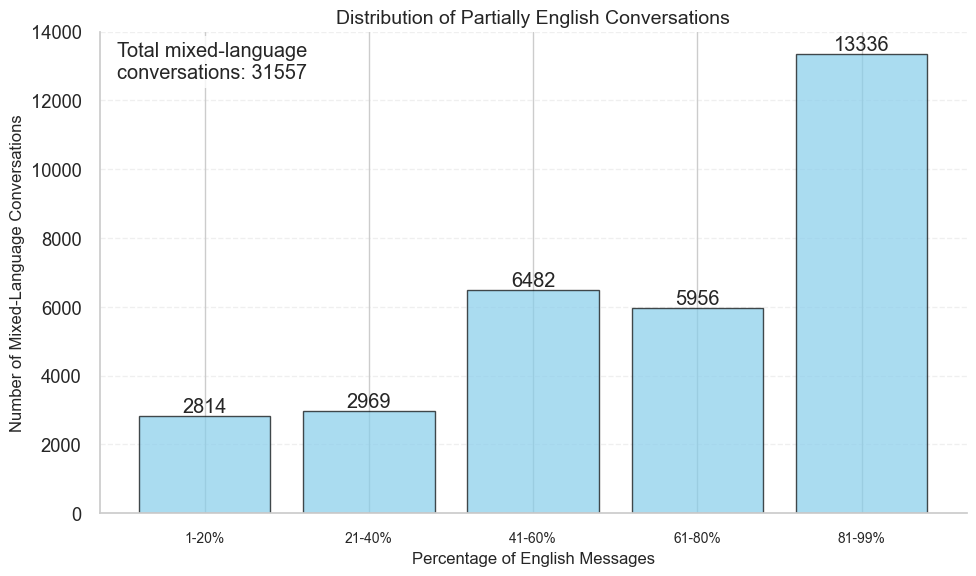

In [374]:
mixed_percentages = [p for p in english_percentages if 0 < p < 100]

# Create ranges for better visualization
ranges = [(0,20), (20,40), (40,60), (60,80), (80,100)]
range_counts = []
for low, high in ranges:
    count = sum(low < p <= high for p in mixed_percentages)
    range_counts.append(count)

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(ranges)), 
               range_counts,
               color='skyblue',
               edgecolor='black',
               alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xticks(range(len(ranges)), 
           ['1-20%', '21-40%', '41-60%', '61-80%', '81-99%'],
           fontsize=10)
plt.ylabel('Number of Mixed-Language Conversations', fontsize=12)
plt.xlabel('Percentage of English Messages', fontsize=12)
plt.title('Distribution of Partially English Conversations', fontsize=14)

plt.grid(True, axis='y', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

total_mixed = len(mixed_percentages)
plt.text(0.02, 0.98, f'Total mixed-language\nconversations: {total_mixed}',
         transform=plt.gca().transAxes,
         ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

In [375]:
df_temp = df_expanded.copy()
df_temp['next_user'] = df_temp.groupby('post_number')['user'].shift(-1)
df_temp['next_language'] = df_temp.groupby('post_number')['language'].shift(-1)

pairs_df = df_temp[
    (df_temp['user'] != 'Chat GPT') & 
    (df_temp['next_user'] == 'Chat GPT')
].copy()

pairs_df = pairs_df[['post_number', 'language', 'next_language']].rename(
    columns={'language': 'user_language', 'next_language': 'chatgpt_language'}
)
pairs_df['pair_order'] = pairs_df.groupby('post_number').cumcount()
print(f"Total pairs: {pairs_df.shape[0]}")
for post_number, group in pairs_df.groupby('post_number'):
    if group['user_language'].nunique() > 1:
        print(group[group['user_language'] != 'unknown'].head(5))
        break


Total pairs: 758239
         post_number user_language chatgpt_language  pair_order
1549455           58            nl               nl           0
1549457           58            en               en           1
1549459           58            en               en           2
1549461           58            en               en           3
1549463           58            en               en           4


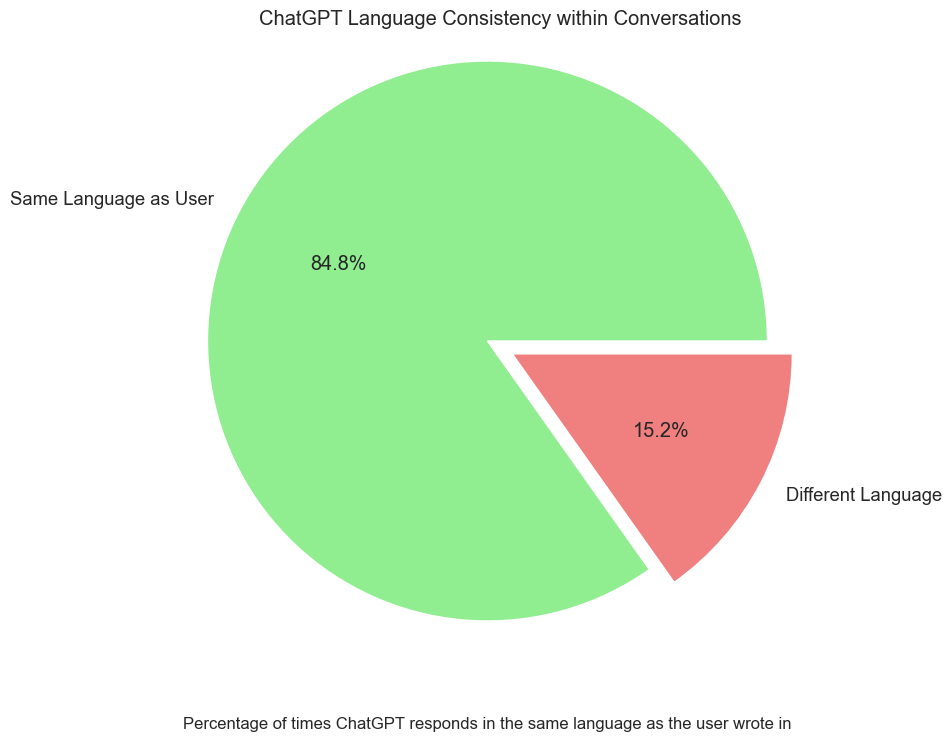

In [376]:
total_pairs = len(pairs_df)
matching_languages = (pairs_df['user_language'] == pairs_df['chatgpt_language']).sum()
percentage_matching = (matching_languages / total_pairs) * 100

plt.figure(figsize=(10, 8))
plt.pie([percentage_matching, 100-percentage_matching], 
        labels=['Same Language as User', 'Different Language'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        explode=(0.1, 0))
plt.title('ChatGPT Language Consistency within Conversations')
plt.figtext(0.5, 0.01, 'Percentage of times ChatGPT responds in the same language as the user wrote in', ha='center', fontsize=12)
plt.axis('equal')

plt.show()

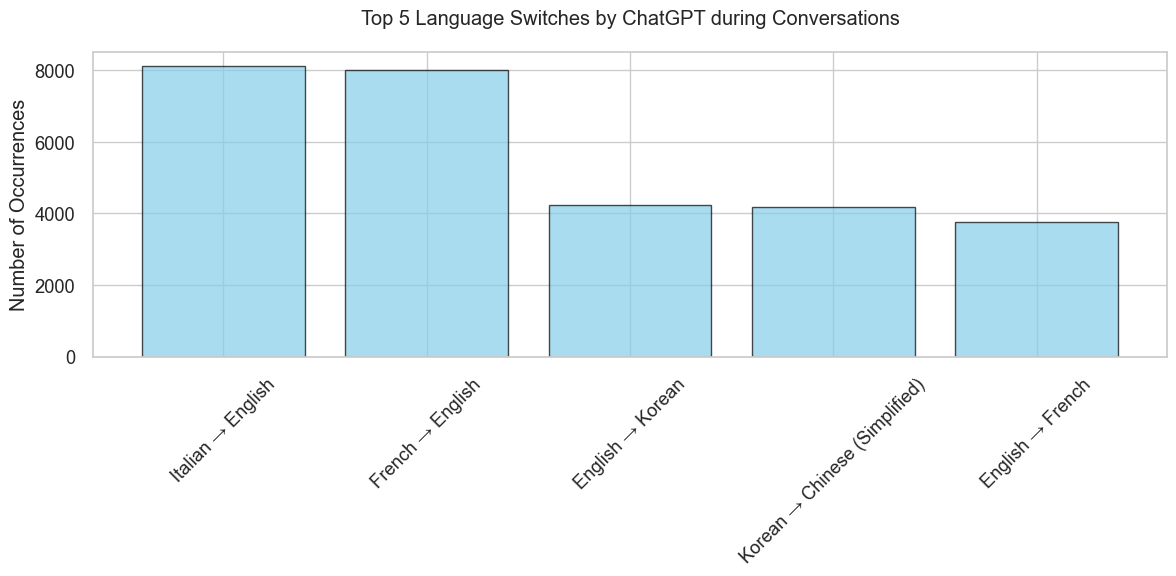

In [377]:
different_lang_responses = pairs_df[pairs_df['user_language'] != pairs_df['chatgpt_language']]

language_switches = different_lang_responses.groupby(['user_language', 'chatgpt_language']).size().reset_index()
language_switches.columns = ['User Language', 'ChatGPT Response', 'Count']
language_switches = language_switches.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
top_5_switches = language_switches.head(5)
plt.bar(range(len(top_5_switches)), top_5_switches['Count'], color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(range(len(top_5_switches)), 
          [f'{get_country_name(row["User Language"])} → {get_country_name(row["ChatGPT Response"])}' 
           for _, row in top_5_switches.iterrows()],
          rotation=45)
plt.title('Top 5 Language Switches by ChatGPT during Conversations', pad=20)
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()

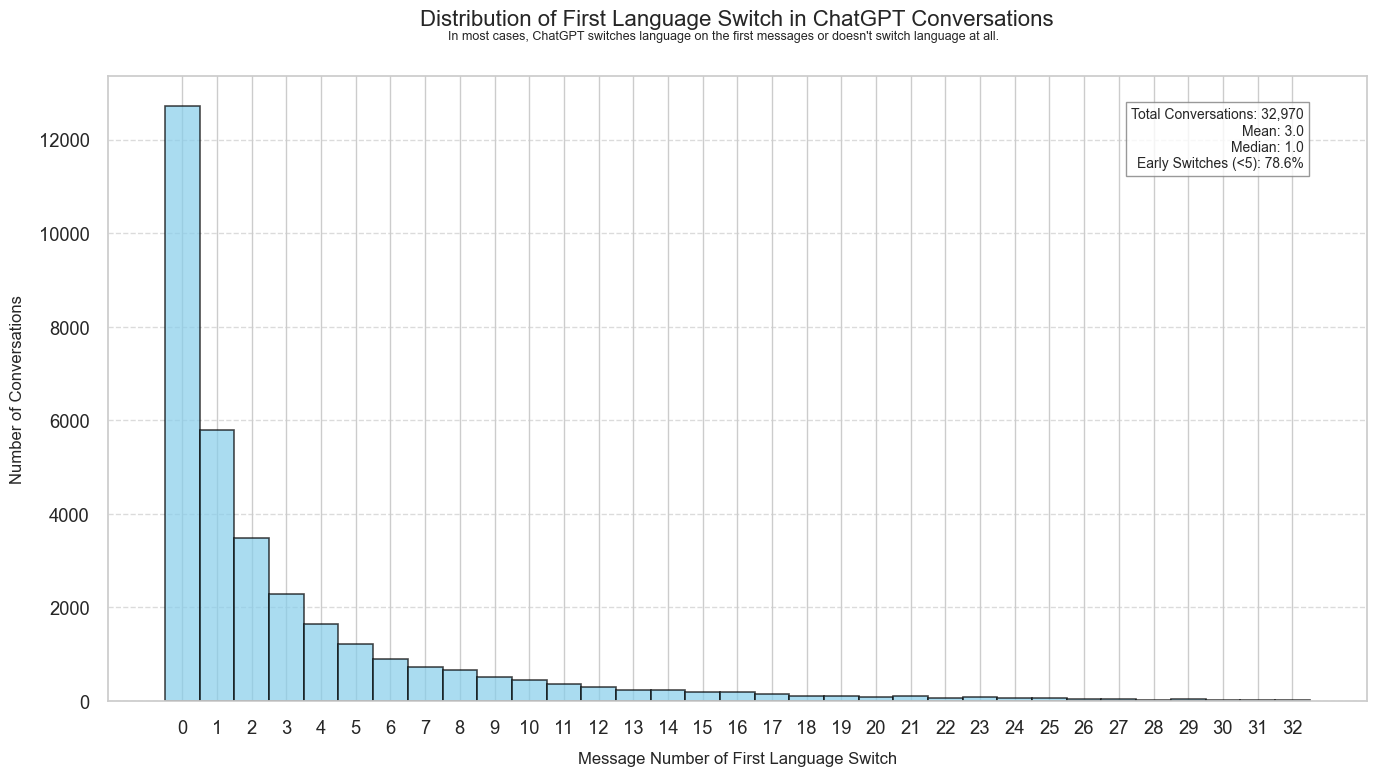

In [67]:
first_mismatches = different_lang_responses.groupby('post_number')[
    'pair_order'].min()
first_mismatches_series = first_mismatches.value_counts().sort_index()
upper_bound = np.percentile(first_mismatches, 99)
filtered_mismatches = first_mismatches[first_mismatches <= upper_bound]

mean_switch = filtered_mismatches.mean()
median_switch = filtered_mismatches.median()
total_samples = len(filtered_mismatches)

fig, ax = plt.subplots(figsize=(14, 8))

max_message = int(np.ceil(filtered_mismatches.max()))
bins = np.arange(0, max_message + 2) - 0.5

n, bins, patches = plt.hist(filtered_mismatches,
                            bins=bins,
                            color='skyblue', 
                            edgecolor='black', 
                            alpha=0.7,
                            linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Distribution of First Language Switch in ChatGPT Conversations\n',
          fontsize=16, pad=20)
plt.xlabel('Message Number of First Language Switch', fontsize=12, labelpad=10)
plt.ylabel('Number of Conversations', fontsize=12, labelpad=10)

stats_text = (f'Total Conversations: {total_samples:,}\n'
              f'Mean: {mean_switch:.1f}\n'
              f'Median: {median_switch:.1f}\n'
              f'Early Switches (<5): {len(filtered_mismatches[filtered_mismatches < 5])/total_samples*100:.1f}%')
plt.text(0.95, 0.95, stats_text,
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=10)

plt.figtext(0.525, 0.935,
            'In most cases, ChatGPT switches language on the first messages or doesn\'t switch language at all.',
            ha='center', fontsize=9)

plt.xticks(np.arange(0, max_message + 1, 1))

plt.tight_layout()
plt.show()

### Sentiment Analysis

In [69]:

from textblob import TextBlob
from tqdm.auto import tqdm

def process_text(text):
    try:
        if isinstance(text, str) and len(text) < 3:
            return 0.0
        return TextBlob(text).sentiment.polarity
    except Exception:
        return 0.0

def process_batch(texts):
    return [process_text(text) for text in texts]

def detect_polarity(df, message_column='message', batch_size=1000, max_workers=12):
    if df.empty:
        return []
    
    messages = df[message_column].values
    total_messages = len(messages)
    
    batch_indices = np.array_split(
        np.arange(total_messages), 
        min(max_workers * 4, total_messages // batch_size + 1)
    )
    batches = [messages[idx] for idx in batch_indices]
    
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]
        
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing sentiment",
            unit="batch"
        ):
            results.extend(future.result())
    
    return results

if 'polarity' in df_expanded.columns:
    print("Using cached polarity scores.")
else:
    print("Calculating polarities...")
    df_expanded['polarity'] = detect_polarity(df_expanded)
    
    print("Saving results to CSV...")
    df_expanded.to_csv(expanded_csv_path, index=False)

Calculating polarities...


Analyzing sentiment:   0%|          | 0/48 [00:01<?, ?batch/s]

Saving results to CSV...


In [70]:
very_negative = df_expanded[df_expanded['polarity'] <= -0.5]
negative = df_expanded[(df_expanded['polarity'] > -0.5) & (df_expanded['polarity'] < 0)]
neutral = df_expanded[df_expanded['polarity'] == 0]
positive = df_expanded[(df_expanded['polarity'] > 0) & (df_expanded['polarity'] < 0.5)]
very_positive = df_expanded[df_expanded['polarity'] >= 0.5]

polarity_summary = {
    'Very Negative': len(very_negative),
    'Negative': len(negative),
    'Neutral': len(neutral),
    'Positive': len(positive),
    'Very Positive': len(very_positive)
}

user_polarity = {
    'Very Negative': len(very_negative[very_negative['user'] == 'Anonymous']),
    'Negative': len(negative[negative['user'] == 'Anonymous']),
    'Neutral': len(neutral[neutral['user'] == 'Anonymous']),
    'Positive': len(positive[positive['user'] == 'Anonymous']),
    'Very Positive': len(very_positive[very_positive['user'] == 'Anonymous'])
}

gpt_polarity = {
    'Very Negative': len(very_negative[very_negative['user'] == 'Chat GPT']),
    'Negative': len(negative[negative['user'] == 'Chat GPT']),
    'Neutral': len(neutral[neutral['user'] == 'Chat GPT']),
    'Positive': len(positive[positive['user'] == 'Chat GPT']),
    'Very Positive': len(very_positive[very_positive['user'] == 'Chat GPT'])
}

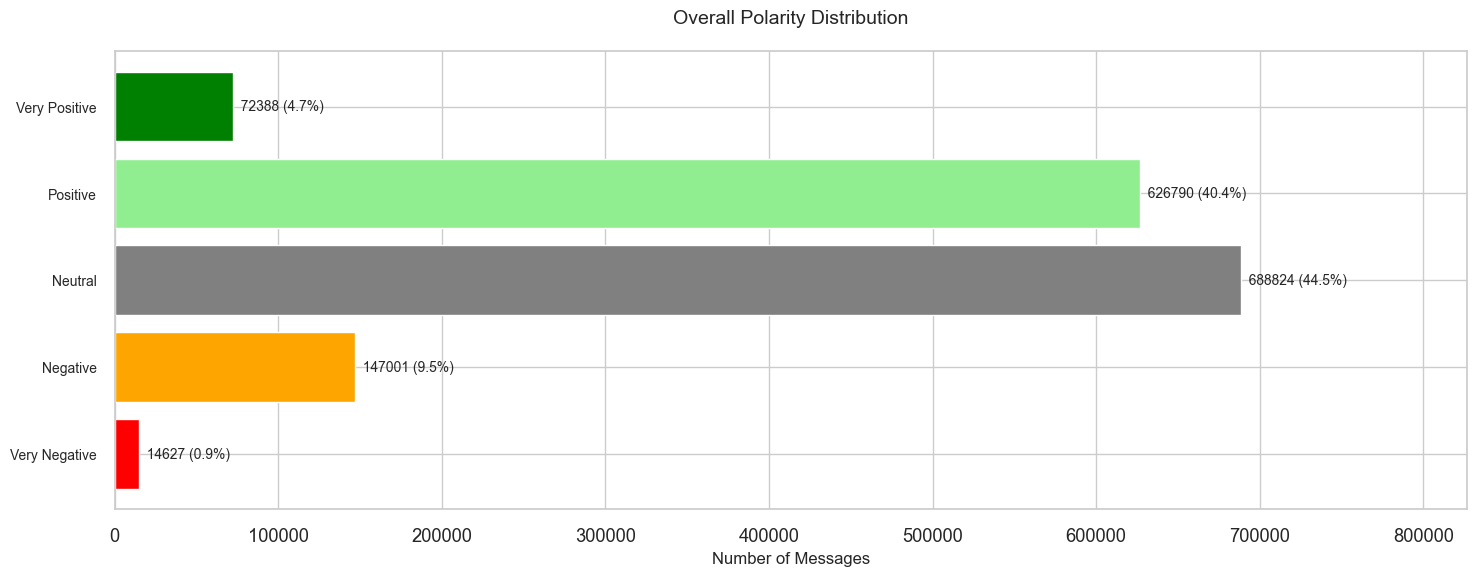

In [71]:
plt.figure(figsize=(15, 6))

total = sum(polarity_summary.values())
y_pos = np.arange(len(polarity_summary))
bars = plt.barh(y_pos, list(polarity_summary.values()),
                color=['red', 'orange', 'gray', 'lightgreen', 'green'])

for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = (width/total) * 100
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'  {int(width)} ({percentage:.1f}%)',
             va='center', fontsize=10)

plt.yticks(y_pos, polarity_summary.keys(), fontsize=10)
plt.xlabel('Number of Messages', fontsize=12)
plt.title('Overall Polarity Distribution', fontsize=14, pad=20)

plt.xlim(0, max(polarity_summary.values()) * 1.2)

plt.tight_layout()
plt.show()

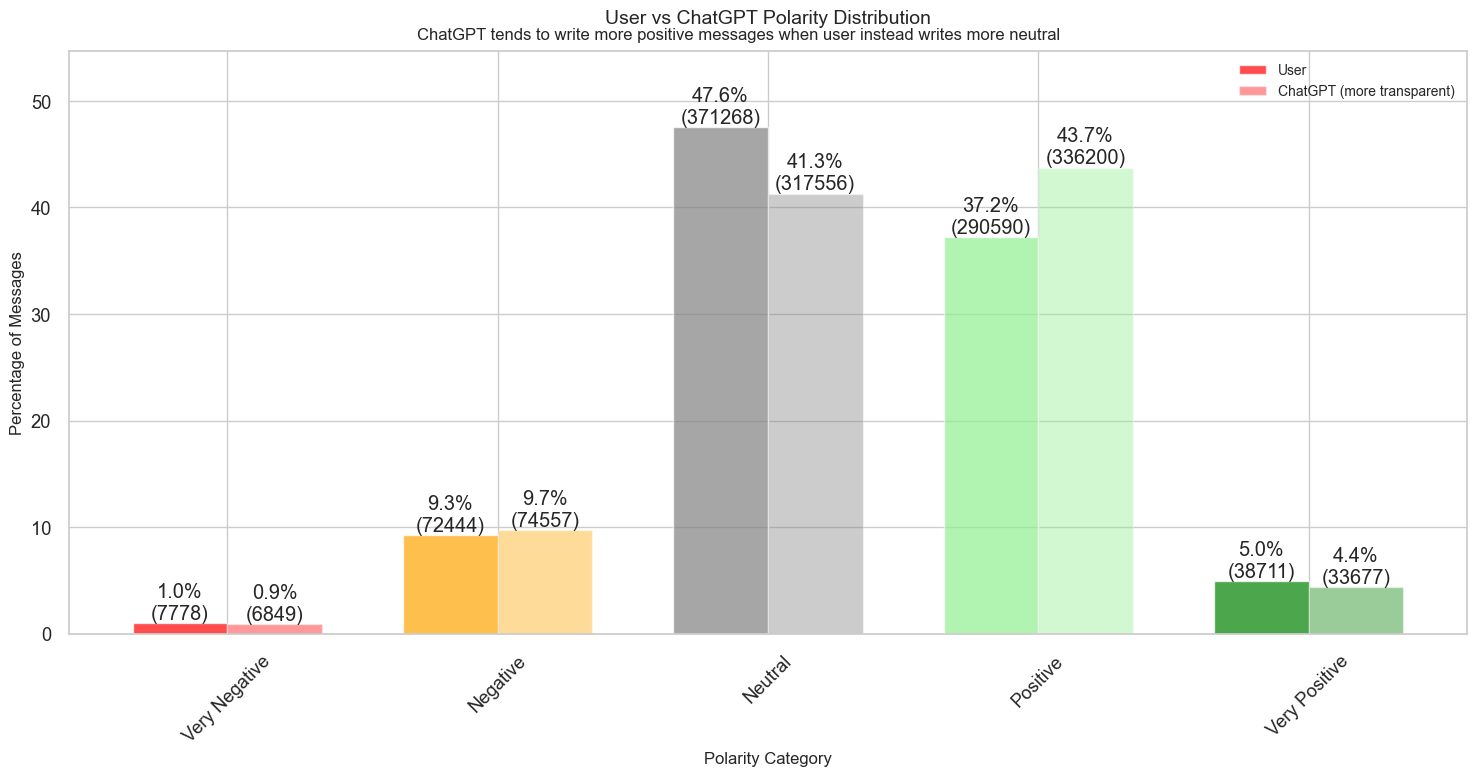

In [72]:
plt.figure(figsize=(15, 8))

categories = list(user_polarity.keys())
x = np.arange(len(categories))
width = 0.35

user_total = sum(user_polarity.values())
gpt_total = sum(gpt_polarity.values())
user_percentages = [v/user_total * 100 for v in user_polarity.values()]
gpt_percentages = [v/gpt_total * 100 for v in gpt_polarity.values()]

bars1 = plt.bar(x - width/2, user_percentages, width, label='User', 
                color=['red', 'orange', 'gray', 'lightgreen', 'green'], alpha=0.7)
bars2 = plt.bar(x + width/2, gpt_percentages, width, label='ChatGPT (more transparent)',
                color=['red', 'orange', 'gray', 'lightgreen', 'green'], alpha=0.4)

def add_labels(bars, raw_values):
    for bar, raw_val in zip(bars, raw_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.1f}%\n({int(raw_val)})',
                ha='center', va='bottom')

add_labels(bars1, user_polarity.values())
add_labels(bars2, gpt_polarity.values())

plt.xlabel('Polarity Category', fontsize=12)
plt.ylabel('Percentage of Messages', fontsize=12)
plt.title('User vs ChatGPT Polarity Distribution', fontsize=14, pad=20)
plt.xticks(x, categories, rotation=45)
plt.legend(fontsize=10)

plt.ylim(0, max(user_percentages + gpt_percentages) * 1.15)

plt.figtext(0.5, 0.935, 'ChatGPT tends to write more positive messages when user instead writes more neutral', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [73]:
df_temp = df_expanded.copy()
df_temp['next_user'] = df_temp.groupby('post_number')['user'].shift(-1)
df_temp['next_polarity'] = df_temp.groupby('post_number')['polarity'].shift(-1)
pairs_df = df_temp[
    (df_temp['user'] == 'Anonymous') & 
    (df_temp['next_user'] == 'Chat GPT')
].copy()
pairs_df = pairs_df.rename(
    columns={
        'polarity': 'user_polarity',
        'next_polarity': 'gpt_polarity'
    }
)
pairs_df

,post_number,user,message,message_order,language,user_polarity,next_user,gpt_polarity
0,57,Anonymous,What is contrastive loss?,0,unknown,0.380682,Chat GPT,0.0000
2,57,Anonymous,Do we need labels for contrastive learning?,2,unknown,0.000000,Chat GPT,0.4375
4,57,Anonymous,"Right, but we still need to know the differenc...",4,unknown,0.000000,Chat GPT,0.0000
6,57,Anonymous,What is the best approach for sampling in cont...,6,unknown,0.000000,Chat GPT,0.0000
8,57,Anonymous,What are the differences and pros/cons of trip...,8,unknown,0.000000,Chat GPT,0.0000
...,...,...,...,...,...,...,...,...
1549619,22628,Anonymous,What is the difference b/n record & class ?,146,en,0.210000,Chat GPT,0.0000
1549621,22628,Anonymous,What is the difference b/n mutable & immutable ?,148,en,0.027381,Chat GPT,0.0000
1549623,22628,Anonymous,What is the difference b/n mutable & immutable...,150,en,0.307273,Chat GPT,0.0000
1549625,22628,Anonymous,can you put it in bulletin format?,152,en,0.329545,Chat GPT,0.0000


In [74]:
def categorize_polarity(score):
    if score <= -0.5:
        return 'Very Negative'
    elif -0.5 < score <= -0.1:
        return 'Negative'
    elif -0.1 < score < 0.1:
        return 'Neutral'
    elif 0.1 <= score < 0.5:
        return 'Positive'
    else:
        return 'Very Positive'

pairs_df['user_polarity_cat'] = pairs_df['user_polarity'].apply(categorize_polarity)
pairs_df['gpt_polarity_cat'] = pairs_df['gpt_polarity'].apply(categorize_polarity)

response_patterns = pd.crosstab(
    pairs_df['user_polarity_cat'], 
    pairs_df['gpt_polarity_cat'],
    normalize='index'
) * 100
response_patterns

gpt_polarity_cat,Negative,Neutral,Positive,Very Negative,Very Positive
user_polarity_cat,,,,,
Negative,11.305268,55.942916,28.121604,1.461420,3.168793
Neutral,3.918421,65.417196,26.423874,0.905938,3.334571
Positive,4.103280,48.871904,40.076431,0.614390,6.333995
Very Negative,10.973684,60.473684,18.552632,7.526316,2.473684
Very Positive,3.250254,37.239152,50.256178,0.410952,8.843465


/var/folders/y5/0t8gc4cj315cwfcx9vxy3kgc0000gn/T/ipykernel_73477/4103524127.py:19: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



<Figure size 1200x1000 with 0 Axes>

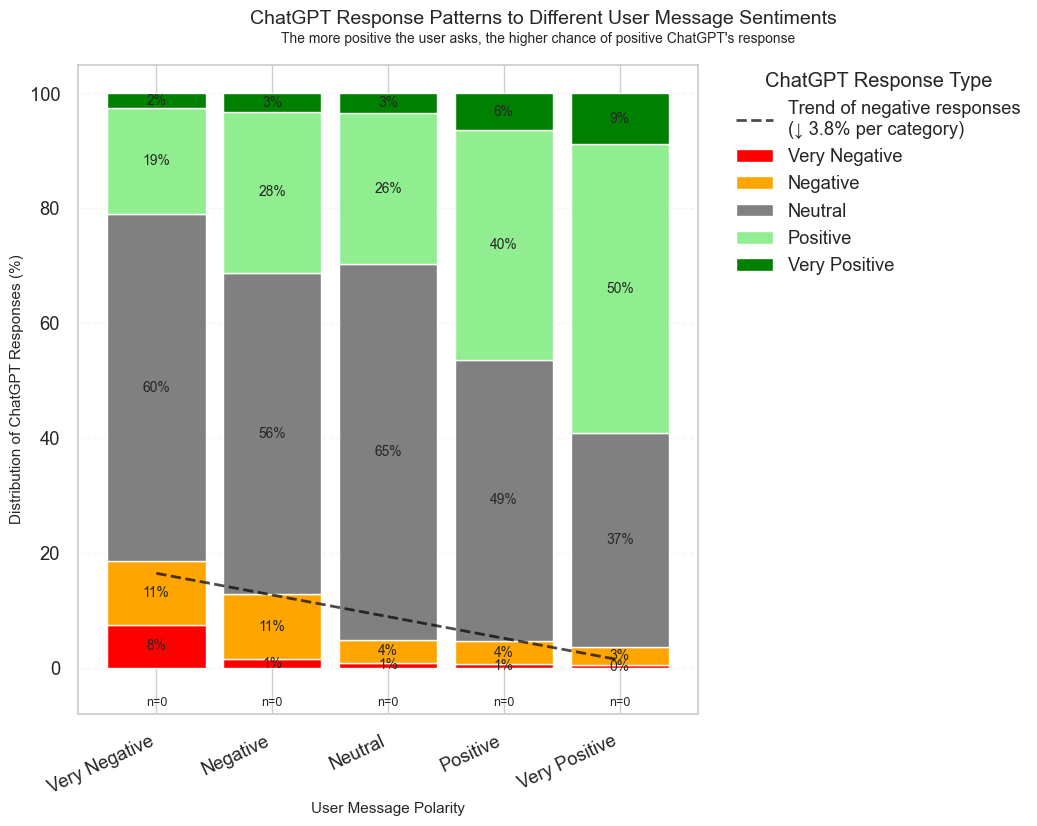

In [75]:
polarity_order = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
response_patterns = response_patterns.reindex(index=polarity_order)
response_patterns = response_patterns.reindex(columns=polarity_order)

plt.figure(figsize=(12, 10))

colors = ['red', 'orange', 'gray', 'lightgreen', 'green']
ax = response_patterns.plot(
    kind='bar',
    stacked=True,
    color=colors,
    width=0.85
)

negative_responses = response_patterns['Negative'] + response_patterns['Very Negative']
x = np.arange(len(polarity_order))
z = np.polyfit(x, negative_responses, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r--', linewidth=2, color='black', alpha=0.7,
         label=f'Trend of negative responses\n(↓ {abs(z[0]):.1f}% per category)')
plt.title('ChatGPT Response Patterns to Different User Message Sentiments', fontsize=14, x=0.75, y=1.05)
plt.suptitle('The more positive the user asks, the higher chance of positive ChatGPT\'s response', fontsize=10, x=0.7, y=0.94)

plt.xlabel('User Message Polarity', fontsize=11)
plt.ylabel('Distribution of ChatGPT Responses (%)', fontsize=11)

plt.xticks(rotation=25, ha='right')

for c in ax.containers:
    ax.bar_label(c, fmt='%.0f%%', label_type='center', fontsize=10)

plt.legend(
    title='ChatGPT Response Type',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

for i, user_pol in enumerate(polarity_order):
    total = len(pairs_df[pairs_df['user_polarity'] == user_pol])
    plt.text(i, -5, f'n={total}', ha='center', va='top', fontsize=9)

plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.ylim(-8, 105)

plt.subplots_adjust(bottom=-0.3)
plt.show()

### Topic Categorization

#### Firstly, I attempted to use BERTopic for topic categorization.
- BERTopic with MiniLM embeddings for semantic understanding
- UMAP for dimensionality reduction
- HDBSCAN for clustering
- Custom preprocessing with domain-specific stopwords

_Note: Also, I was trying to make it work with all languages, but for simplicity I decided to only use English conversations._

#### However, this approach had several significant limitations.
1. Performance issues, 2.5 hours for dataset (89k first messages of conversations on M1 PRO)
2. Needs more time to train and tune the model: most conversations were grouped into a single generic topic.

P.S. On smaller results e.g. 5k messages it was faster and gave better results.

**Remaining this approach commented out with its results.**

In [ ]:
df_expanded['message_order'] = df_expanded.groupby('post_number').cumcount()

In [96]:
# import os
# import pandas as pd
# import numpy as np
# import re
# from bertopic import BERTopic
# from sklearn.feature_extraction.text import CountVectorizer
# from umap import UMAP
# from hdbscan import HDBSCAN
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# import nltk
# import pickle
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# def analyze_chat_topics(df_expanded, output_dir='data', sample_size=2500, force_rerun=False):
#     os.makedirs(output_dir, exist_ok=True)
    
#     output_file = os.path.join(output_dir, 'topic_analysis_results.csv')
#     model_file = os.path.join(output_dir, 'topic_model.pkl')
    
#     if not force_rerun and os.path.exists(output_file) and os.path.exists(model_file):
#         print("Loading cached results...")
#         results_df = pd.read_csv(output_file)
#         with open(model_file, 'rb') as f:
#             topic_model = pickle.load(f)
#         return results_df, topic_model

#     nltk.download('punkt_tab', quiet=True)
#     nltk.download('stopwords', quiet=True)
#     nltk.download('wordnet', quiet=True)

#     # Setup environment and stop words
#     os.environ["TOKENIZERS_PARALLELISM"] = "false"
#     stop_words = set(stopwords.words('english'))
#     lemmatizer = WordNetLemmatizer()
    
#     custom_stops = {
#         # Basic conversation starters
#         'help', 'please', 'thanks', 'thank', 'hello', 'hi', 'hey',
#         'could', 'would', 'tell', 'explain', 'need', 'want', 'like',
        
#         # ChatGPT-specific terms
#         'chatgpt', 'gpt', 'ai', 'assistant', 'bot', 'chat',
#         'prompt', 'response', 'answer', 'question',
        
#         # Request-related words
#         'wondering', 'asking', 'trying', 'looking', 'seeking',
#         'hope', 'hoping', 'think', 'thought', 'wondering',
        
#         # Common instruction words
#         'can', 'will', 'should', 'must', 'may', 'might',
#         'write', 'generate', 'create', 'make', 'give',
#         'show', 'tell', 'explain', 'describe', 'provide',
#     }
#     stop_words.update(custom_stops)

#     def preprocess_text(text):
#         if not isinstance(text, str):
#             return ''
        
#         text = text.lower()
#         text = re.sub(r'[^a-z\s?.!,]', '', text)
#         text = re.sub(r'\s+', ' ', text)
#         tokens = word_tokenize(text)
        
#         tokens = [
#             lemmatizer.lemmatize(word) 
#             for word in tokens 
#             if word not in stop_words 
#             and len(word) > 1
#             and not word.isnumeric()
#         ]
        
#         return ' '.join(tokens)

#     print("Processing English conversations...")
#     english_conversations_first_messages = df_expanded[
#         (df_expanded['language'] == 'en') & 
#         (df_expanded['message_order'] == 0)
#     ]
#     valid_conversations = english_conversations_first_messages['post_number'].unique()
#     if sample_size == -1:
#         sampled_conversations = valid_conversations
#     else:
#         indices = np.random.permutation(len(valid_conversations))[:min(sample_size, len(valid_conversations))]
#         sampled_conversations = valid_conversations[indices]

#     processed_data = []
#     filtered_df = df_expanded[df_expanded['post_number'].isin(sampled_conversations)]

#     for conv_id in tqdm(sampled_conversations):
#         conv_messages = filtered_df[filtered_df['post_number'] == conv_id]
#         user_messages = conv_messages[conv_messages['user'] == 'Anonymous']
#         if not user_messages.empty:
#             message = user_messages.iloc[0]['message']
#             if len(str(message).strip()) < 20:
#                 continue
#             processed_text = preprocess_text(str(message))
#             if processed_text:
#                 processed_data.append((conv_id, processed_text))

#     conversation_ids, initial_queries = zip(*processed_data)

#     print("Initializing BERTopic model...")
#     topic_model = BERTopic(
#         embedding_model="all-MiniLM-L6-v2",
#         umap_model=UMAP(
#             n_neighbors=50,
#             n_components=5,
#             min_dist=0.05,
#             metric='cosine',
#             random_state=42
#         ),
#         hdbscan_model=HDBSCAN(
#             min_cluster_size=10,
#             min_samples=2,
#             metric='euclidean',
#             cluster_selection_epsilon=0.2,
#             prediction_data=True,
#             cluster_selection_method='leaf'
#         ),
#         vectorizer_model=CountVectorizer(
#             stop_words='english',
#             ngram_range=(1, 3),
#             min_df=1,
#             max_df=0.99,
#             max_features=5000
#         ),
#         language='english',
#         calculate_probabilities=True,
#         min_topic_size=10,
#         nr_topics=30,
#         verbose=True
#     )

#     print("Fitting BERTopic model...")
#     topics, probs = topic_model.fit_transform(initial_queries)

#     results_df = pd.DataFrame({
#         'post_number': conversation_ids,
#         'topic': topics,
#         'probability': [max(p) if len(p) > 0 else 0 for p in probs],
#         'initial_query': initial_queries
#     })

#     results_df.to_csv(output_file, index=False)
#     with open(model_file, 'wb') as f:
#         pickle.dump(topic_model, f)

#     return results_df, topic_model

# results_df, topic_model = analyze_chat_topics(
#     df_expanded,
#     output_dir='data',
#     sample_size=-1,
#     force_rerun=False
# )

Processing English conversations...


100%|██████████| 64757/64757 [01:05<00:00, 984.48it/s] 
2024-11-08 23:03:01,565 - BERTopic - Embedding - Transforming documents to embeddings.


Initializing BERTopic model...
Fitting BERTopic model...


Batches:   0%|          | 0/1859 [00:00<?, ?it/s]

2024-11-08 23:12:38,746 - BERTopic - Embedding - Completed ✓
2024-11-08 23:12:38,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-08 23:14:07,994 - BERTopic - Dimensionality - Completed ✓
2024-11-08 23:14:07,999 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-09 01:41:59,206 - BERTopic - Cluster - Completed ✓
2024-11-09 01:41:59,268 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-09 01:42:23,457 - BERTopic - Representation - Completed ✓
2024-11-09 01:42:23,462 - BERTopic - Topic reduction - Reducing number of topics
2024-11-09 01:42:38,610 - BERTopic - Topic reduction - Reduced number of topics from 289 to 30



Topic 0: 48151 documents
Top words and their scores:
- use: 0.010
- data: 0.010
- using: 0.009
- new: 0.009
- time: 0.009
- work: 0.008
- la: 0.008
- information: 0.008
- result: 0.007
- dan: 0.007

Topic 1: 964 documents
Top words and their scores:
- chinese: 0.083
- korean: 0.075
- facebook: 0.046
- language: 0.046
- tweet: 0.045
- temple: 0.043
- dream: 0.037
- korea: 0.035
- english: 0.035
- twitter: 0.032

Topic 2: 474 documents
Top words and their scores:
- audio: 0.082
- video: 0.075
- speech: 0.067
- mp: 0.048
- file: 0.047
- youtube: 0.041
- import: 0.040
- sound: 0.038
- speaker: 0.036
- voice: 0.035

Topic 3: 290 documents
Top words and their scores:
- quantum: 0.388
- quantum computing: 0.270
- computing: 0.248
- quantum computing simple: 0.229
- computing simple: 0.229
- computing simple term: 0.221
- simple term: 0.208
- simple term quantum: 0.176
- term quantum: 0.176
- term quantum computing: 0.171

Topic 4: 224 documents
Top words and their scores:
- birthday: 0.361
-

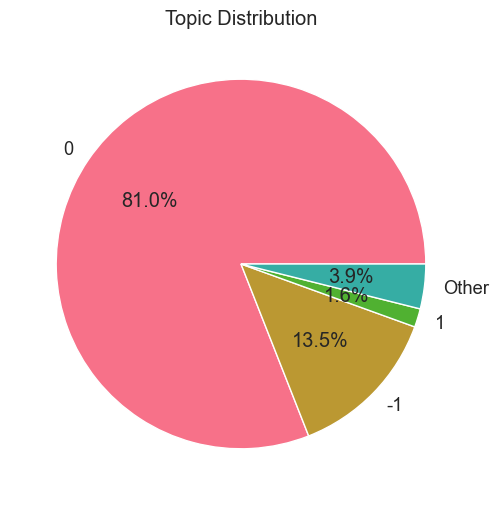

In [379]:
# topic_info = topic_model.get_topic_info()

# for topic in topic_info.itertuples():
#     if topic.Topic != -1 and topic.Topic < 5:
#         print(f"\nTopic {topic.Topic}: {topic.Count} documents")
#         top_words = topic_model.get_topic(topic.Topic)
#         print("Top words and their scores:")
#         for word, score in top_words[:10]:
#             print(f"- {word}: {score:.3f}")
            
# topic_counts = results_df['topic'].value_counts()
# topic_pct = topic_counts / len(results_df) * 100

# mask = topic_pct >= 1.5
# large_topics = topic_pct[mask]
# other = pd.Series({'Other': topic_pct[~mask].sum()})
# final_counts = pd.concat([large_topics, other])

# plt.figure(figsize=(10, 6))
# plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%')
# plt.title('Topic Distribution')
# plt.show()

It wasn't clear enough for me what each topic was about, so I decided to use `gpt-4o-mini` to label each topic based on the top words.

In [131]:
# from openai import OpenAI
# from dotenv import load_dotenv

# load_dotenv()
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# def get_topic_label(topic_words, client):
#     word_list = "\n".join([f"- {word}: {score:.3f}" for word, score in topic_words[:10]])
    
#     try:
#         response = client.chat.completions.create(
#             model="gpt-4o-mini",
#             messages=[
#                 {
#                     "role": "system", 
#                     "content": "You are a topic labeling assistant. Provide a single specific word to categorize ChatGPT conversations. Never use 'outlier' or 'misc'."
#                 },
#                 {
#                     "role": "user",
#                     "content": f"""These are topic-related words from ChatGPT conversations:

# {word_list}

# Examples:
# - For words like "code, python, function": respond with "programming"
# - For words like "essay, write, thesis": respond with "writing"
# - For words like "math, equation, solve": respond with "mathematics"

# Provide ONE specific word that best describes this topic. Just the word, no explanation."""
#                 }
#             ],
#             temperature=0.2,
#         )
#         return response.choices[0].message.content.strip().lower()
#     except Exception as e:
#         print(f"Error getting label: {e}")
#         return "error"

# def label_topics(topic_model):
#     topic_info = topic_model.get_topic_info()
    
#     print("\nLabeling Topics:")
#     print("-" * 50)
#     print(f"{'Topic':^6} | {'Label':^15} | {'Documents':^10}")
#     print("-" * 50)
    
#     for _, row in topic_info.iterrows():
#         if row.Topic != -1:
#             words = topic_model.get_topic(row.Topic)
#             label = get_topic_label(words, client)
#             topic_info.loc[topic_info['Topic'] == row.Topic, 'label'] = label
#             print(f"{row.Topic:^6} | {label:^15} | {row.Count:^10}")
    
#     print("-" * 50)
    
#     topic_info.to_csv('data/topic_labels.csv', index=False)
#     return topic_info

# topic_info_labeled = label_topics(topic_model)



Labeling Topics:
--------------------------------------------------
Topic  |      Label      | Documents 
--------------------------------------------------
  0    |    analysis     |   48151   
  1    |    language     |    964    
  2    |      audio      |    474    
  3    |     quantum     |    290    
  4    |    birthday     |    224    
  5    | webdevelopment  |    142    
  6    |     fantasy     |    137    
  7    |    beverage     |    106    
  8    |   scheduling    |     95    
  9    |    identity     |     94    
  10   |  optimization   |     80    
  11   |   earthquake    |     74    
  12   |    streaming    |     69    
  13   |   ornithology   |     69    
  14   |      drama      |     69    
  15   |  documentation  |     66    
  16   |     sports      |     51    
  17   |   automation    |     49    
  18   |     django      |     38    
  19   |     physics     |     32    
  20   |   programming   |     25    
  21   |   agriculture   |     24    
  22  

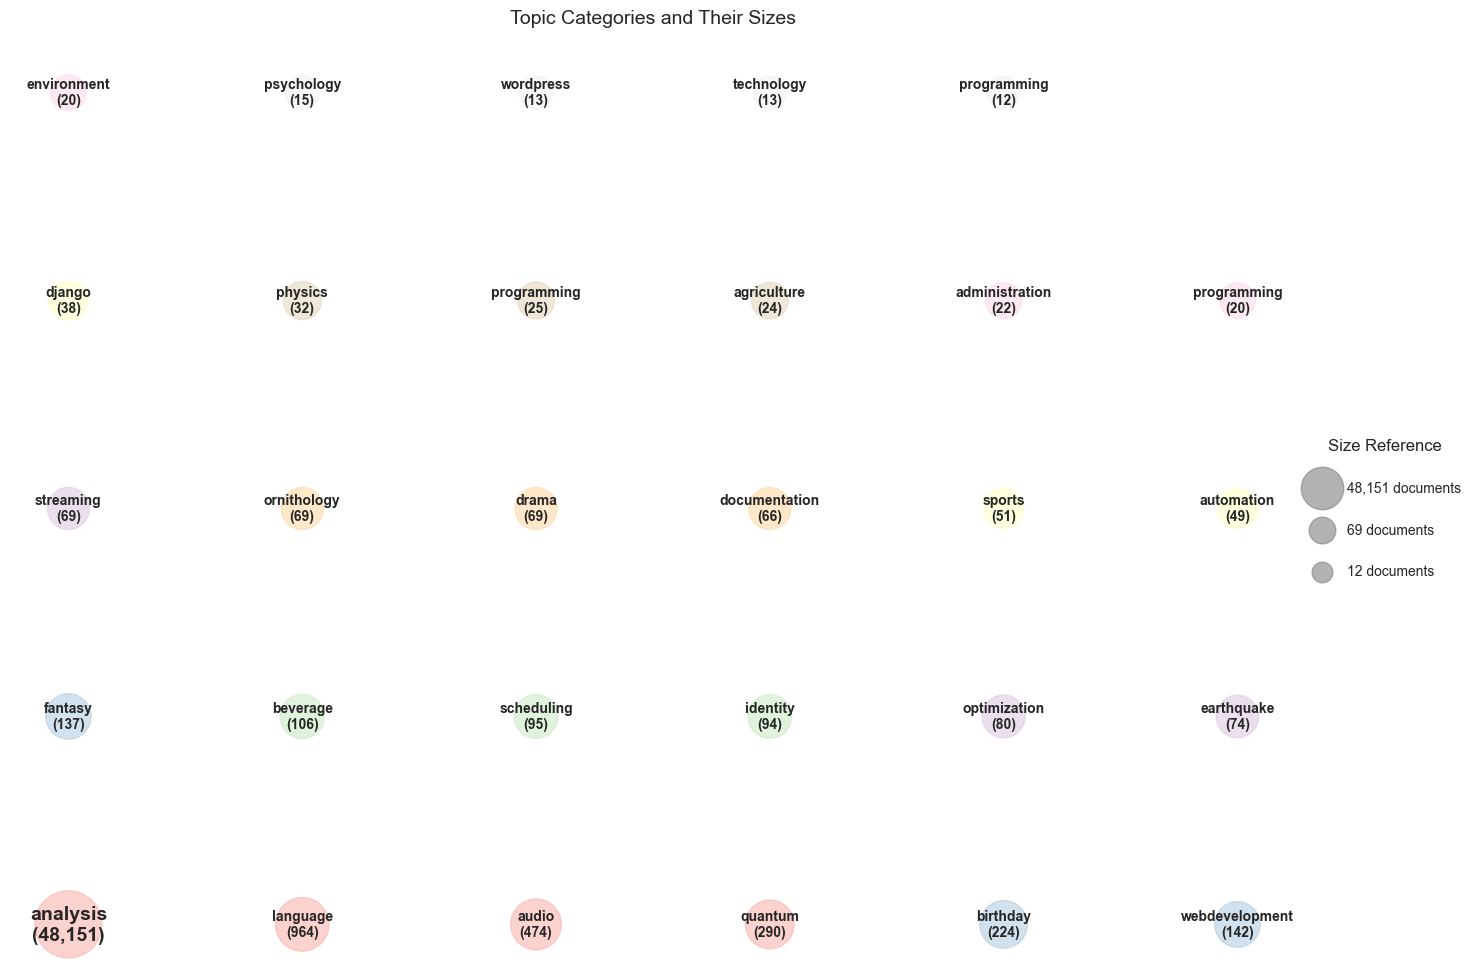

In [140]:
# def plot_topic_bubbles(topic_info_labeled):
#     topics = topic_info_labeled[topic_info_labeled['Topic'] != -1]
#     labels = topics['label'].values
#     sizes = topics['Count'].values
    
#     bubble_sizes = np.log10(sizes + 1) * 500
    
#     num_topics = len(labels)
#     cols = int(np.ceil(np.sqrt(num_topics)))
#     rows = int(np.ceil(num_topics / cols))
    
#     x = np.arange(cols) * 2  
#     y = np.arange(rows) * 1.5
#     x, y = np.meshgrid(x, y)
#     x = x.flatten()[:num_topics]
#     y = y.flatten()[:num_topics]
    
#     plt.figure(figsize=(15, 10))
    
#     colors = plt.cm.Pastel1(np.linspace(0, 1, num_topics))
#     plt.scatter(x, y, s=bubble_sizes, alpha=0.6, c=colors)
    
#     for i, (label, size) in enumerate(zip(labels, sizes)):
#         font_size = min(max(10, np.log10(size + 1) * 3), 14)
        
#         plt.annotate(
#             f'{label}\n({size:,})', 
#             (x[i], y[i]),
#             ha='center', 
#             va='center',
#             fontsize=font_size,
#             fontweight='bold'
#         )
    
#     plt.title('Topic Categories and Their Sizes', pad=20, fontsize=14)
#     plt.axis('off')

#     legend_sizes = [min(sizes), np.median(sizes), max(sizes)]
#     legend_elements = [
#         plt.scatter(
#             [], [], 
#             s=np.log10(size + 1) * 200, 
#             c='gray', 
#             alpha=0.6, 
#             label=f'{int(size):,} documents'
#         ) 
#         for size in sorted(legend_sizes, reverse=True)
#     ]
#     plt.legend(
#         handles=legend_elements, 
#         title='Size Reference',
#         title_fontsize=12,
#         fontsize=10,
#         loc='center left', 
#         bbox_to_anchor=(1, 0.5),
#         scatterpoints=1,
#         labelspacing=2
#     )
    
#     plt.tight_layout()
#     plt.show()

# plot_topic_bubbles(topic_info_labeled)

So then I've decided to take other, simpler approach:
- TF-IDF instead of BERTopic
- MiniBatchKMeans instead of HDBSCAN
- TruncatedSVD instead of UMAP

In [202]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm

def setup_nltk():
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    
    stop_words = set(stopwords.words('english'))
    stop_words.update({
        # Basic conversation
        'help', 'please', 'thanks', 'hello', 'hi', 'chatgpt', 'gpt', 'ai',
        'could', 'would', 'tell', 'explain', 'need', 'want', 'like',
        # Common words that create noise
        'one', 'way', 'use', 'also', 'however', 'tell', 'would', 'could',
        'should', 'example', 'information', 'different', 'new', 'try',
        'provide', 'following', 'work', 'list', 'time', 'first', 'question',
        'answer', 'write', 'know', 'help', 'want', 'like', 'good',
        # Command words
        'can', 'will', 'should', 'make', 'create', 'generate', 'give',
        'show', 'explain', 'describe', 'provide', 'tell', 'write',
        # Common ChatGPT-specific words
        'prompt', 'response', 'message', 'chat', 'asking', 'question',
        'answer', 'request', 'task', 'output', 'result'
    })
    
    return stop_words, WordNetLemmatizer()

def preprocess_text(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ''
        
    text = text.lower()
    text = re.sub(r'[^a-z\s?.!,]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
             if word not in stop_words and len(word) > 1]
    
    return ' '.join(tokens)

def get_initial_messages(df, min_text_length=20, sample_size=-1):
    initial_messages = df[
        (df['message_order'] == 0) & 
        (df['user'] == 'Anonymous') &
        (df['language'] == 'en') &
        (df['message'].str.len() >= min_text_length)
    ].copy()
    
    if sample_size != -1:
        initial_messages = initial_messages.sample(
            n=min(sample_size, len(initial_messages)), 
            random_state=42
        )
    
    return initial_messages

def process_texts(messages, stop_words, lemmatizer):
    processed_texts = [
        preprocess_text(text, stop_words, lemmatizer) 
        for text in tqdm(messages['message'])
    ]
    
    valid_indices = [i for i, text in enumerate(processed_texts) 
                    if len(text.strip()) > 0]
    
    return [processed_texts[i] for i in valid_indices], valid_indices

def vectorize_and_reduce(texts, n_components=100):
    vectorizer = TfidfVectorizer(
        max_features=15000,
        ngram_range=(1, 3),
        min_df=3,
        max_df=0.90,
        sublinear_tf=True
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)
    
    norms = np.linalg.norm(reduced_matrix, axis=1)
    norms[norms == 0] = 1
    reduced_matrix = reduced_matrix / norms[:, np.newaxis]
    reduced_matrix = np.nan_to_num(reduced_matrix)
    
    return tfidf_matrix, reduced_matrix, vectorizer

def get_topic_keywords(tfidf_matrix, cluster_labels, vectorizer, n_topics):
    topic_keywords = {}
    
    for topic_id in range(n_topics):
        cluster_docs = tfidf_matrix[cluster_labels == topic_id]
        if cluster_docs.shape[0] > 0:
            avg_tfidf = cluster_docs.mean(axis=0).A1
            top_indices = avg_tfidf.argsort()[-10:][::-1]
            keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
            topic_keywords[topic_id] = ', '.join(keywords)
            
    return topic_keywords

def create_results_dataframe(initial_messages, cluster_labels, topic_keywords, 
                           processed_texts, valid_indices):
    initial_messages = initial_messages.iloc[valid_indices].reset_index(drop=True)
    
    results_df = pd.DataFrame({
        'post_number': initial_messages['post_number'].values,
        'topic': cluster_labels,
        'topic_keywords': [topic_keywords[t] for t in cluster_labels],
        'topic_size': pd.Series(cluster_labels).map(pd.Series(cluster_labels).value_counts()),
        'processed_text': processed_texts,
        'original_message': initial_messages['message'].values
    })
    
    return results_df.sort_values(['topic_size', 'topic'], ascending=[False, True])

def analyze_topics(df_expanded, output_dir='data', n_topics=30, 
                  sample_size=-1, min_text_length=30):
    os.makedirs(output_dir, exist_ok=True)
    
    stop_words, lemmatizer = setup_nltk()
    initial_messages = get_initial_messages(df_expanded, min_text_length, sample_size)
    
    processed_texts, valid_indices = process_texts(initial_messages, stop_words, lemmatizer)
    
    try:
        tfidf_matrix, reduced_matrix, vectorizer = vectorize_and_reduce(processed_texts)
        
        kmeans = MiniBatchKMeans(
            n_clusters=n_topics,
            random_state=42,
            batch_size=2000,
            max_iter=300,
            init='k-means++',
            n_init=10
        )
        cluster_labels = kmeans.fit_predict(reduced_matrix)
        
        topic_keywords = get_topic_keywords(tfidf_matrix, cluster_labels, vectorizer, n_topics)
        results_df = create_results_dataframe(
            initial_messages, cluster_labels, topic_keywords, 
            processed_texts, valid_indices
        )
        
        results_df.to_csv(os.path.join(output_dir, 'topic_analysis_results.csv'), index=False)
        
        print("\nTopic Distribution:")
        summary = results_df.groupby('topic').agg({
            'post_number': 'count',
            'topic_keywords': 'first'
        }).sort_values('post_number', ascending=False)
        print(summary)
        
        return results_df
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        raise

fast_topic_df = analyze_topics(
    df_expanded,
    n_topics=30,
    min_text_length=30
)

100%|██████████| 58018/58018 [00:29<00:00, 1985.20it/s]



Topic Distribution:
       post_number                                     topic_keywords
topic                                                                
10           17966  using, code, english, language, data, file, ap...
4             3401  research, human, student, technology, experien...
26            3292  day, many, people, life, plan, friend, food, m...
16            3196  used, state, number, process, set, order, data...
7             3034  im, say, thing, dont, think, get, something, g...
21            2866  return, function, string, import, const, value...
1             2497  project, software, product, manager, job, deve...
12            1747  company, business, marketing, tech, plan, star...
15            1428  question, ask, ask question, interview, answer...
5             1344  table, column, sql, database, row, query, id, ...
13            1303  python, code, python code, using, code python,...
29            1102  result, search result, search, url, web search...

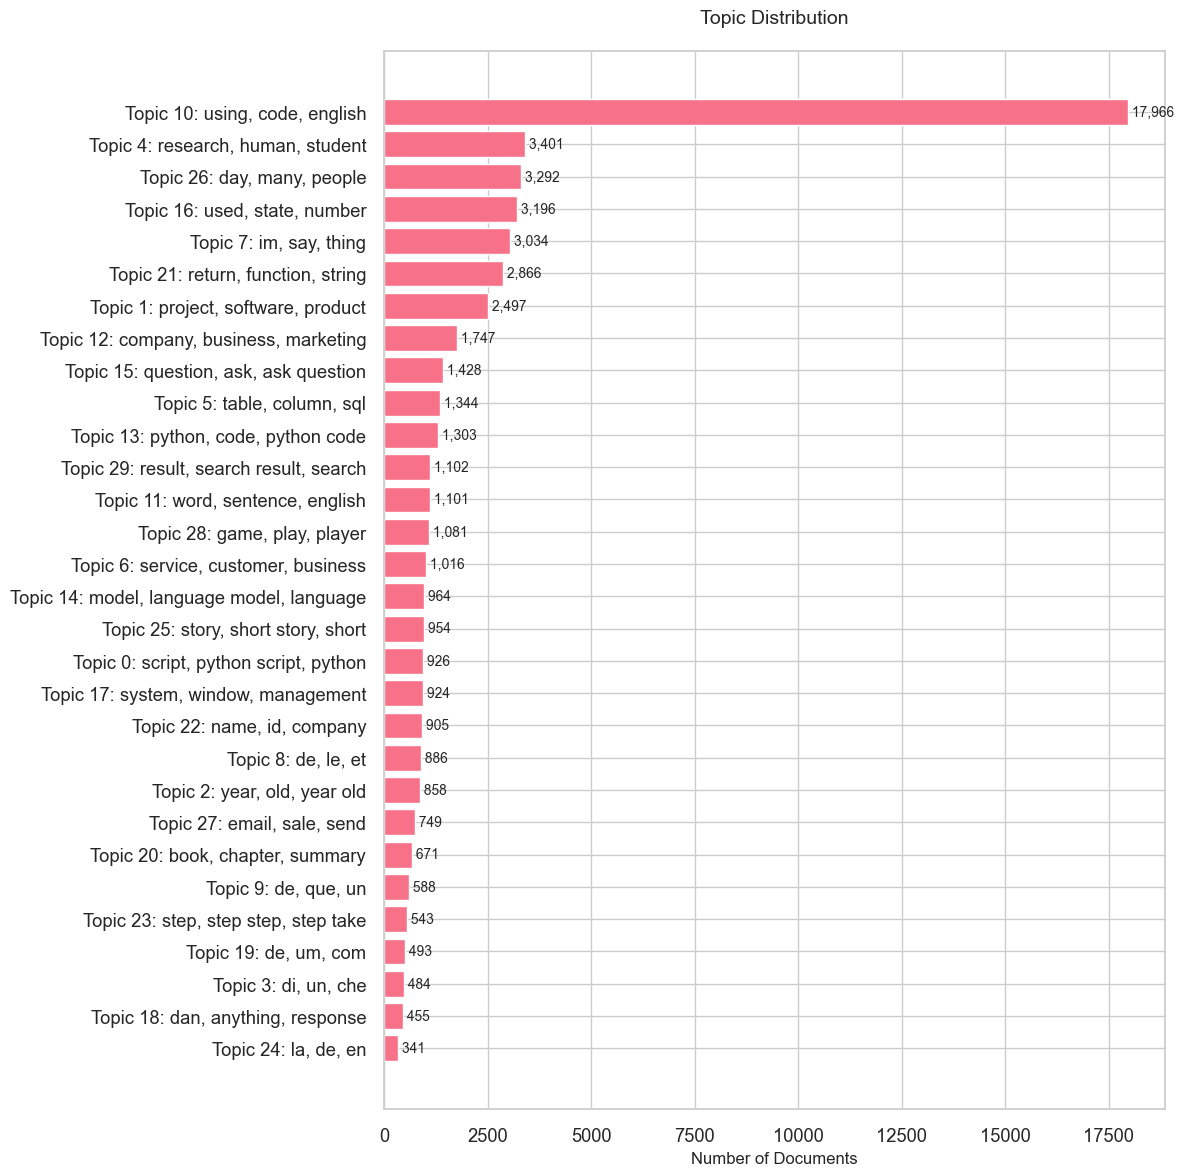

In [203]:
def plot_topic_distribution(results_df):
    topic_counts = results_df['topic'].value_counts()
    topic_sizes = topic_counts.sort_values(ascending=True)
    
    height_per_topic = 0.4
    fig_height = max(8, len(topic_sizes) * height_per_topic)
    
    plt.figure(figsize=(12, fig_height))
    
    y_pos = np.arange(len(topic_sizes))
    bars = plt.barh(y_pos, topic_sizes.values)
    
    plt.xlabel('Number of Documents', fontsize=12)
    plt.title('Topic Distribution', fontsize=14, pad=20)
    
    labels = []
    for topic_id in topic_sizes.index:
        keywords = results_df[results_df['topic'] == topic_id]['topic_keywords'].iloc[0]
        top_keywords = keywords.split(', ')[:3]
        labels.append(f'Topic {topic_id}: {", ".join(top_keywords)}')
    
    plt.yticks(y_pos, labels)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f' {int(width):,}',
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_topic_distribution(fast_topic_df)


In [209]:
from dotenv import load_dotenv
from openai import OpenAI
from pathlib import Path
import pandas as pd

def get_topic_label(keywords, existing_labels, client):
    """Get a topic label, considering existing labels for potential merging"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "Create general topic labels or reuse existing ones if similar. Return exactly one label."
                },
                {
                    "role": "user",
                    "content": f"""Keywords: {keywords}

Existing labels so far: {existing_labels if existing_labels else 'None yet'}

Examples:
Input: marketing, finance, strategy, sales
Output: business

Input: code, python, function, debug
Output: programming

If the keywords are similar to an existing label's topic, use that label.
Otherwise, create a new general label (1-2 words).
Return only the label, no explanation."""
                }
            ],
            temperature=0.1
        )
        return response.choices[0].message.content.strip().lower()
    except Exception as e:
        print(f"Error getting label: {e}")
        return "error"

def label_topics(results_df, output_path='data/fast_topic_labels.csv'):
    if Path(output_path).exists():
        print(f"Loading cached labels from {output_path}")
        return pd.read_csv(output_path)
    
    load_dotenv()
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    topic_info = results_df.groupby('topic').agg({
        'topic_keywords': 'first',
        'topic_size': 'first'
    }).reset_index()
    
    topic_info = topic_info.sort_values('topic_size', ascending=False)
    
    labels = []
    existing_labels = []
    topic_mapping = {}
    
    for _, row in topic_info.iterrows():
        label = get_topic_label(row['topic_keywords'], existing_labels, client)
        labels.append(label)
        
        if label not in existing_labels:
            existing_labels.append(label)
            topic_mapping[label] = [row['topic']]
        else:
            print(f"Merging topic {row['topic']} into existing label '{label}'")
            topic_mapping[label].append(row['topic'])
    
    topic_info['label'] = labels
    
    merged_topics = {}
    for label, topics in topic_mapping.items():
        if len(topics) > 1:
            main_topic = min(topics)
            for topic in topics:
                if topic != main_topic:
                    merged_topics[topic] = main_topic
                    
                    main_size = topic_info.loc[topic_info['topic'] == main_topic, 'topic_size'].iloc[0]
                    merged_size = topic_info.loc[topic_info['topic'] == topic, 'topic_size'].iloc[0]
                    topic_info.loc[topic_info['topic'] == main_topic, 'topic_size'] = main_size + merged_size
                    topic_info = topic_info[topic_info['topic'] != topic]
            
            print(f"\nMerged topics {topics} into topic {main_topic} with label '{label}'")
    
    results_df['topic'] = results_df['topic'].map(lambda x: merged_topics.get(x, x))
    
    topic_info.to_csv(output_path, index=False)
    print(f"\nLabels saved to {output_path}")
    
    return topic_info

topic_info_labeled = label_topics(fast_topic_df)

Loading cached labels from data/fast_topic_labels.csv


In [211]:
print("-" * 50)
print(f"{'Topic':^6} | {'Label':^28} | {'Size':^10}")
print("-" * 50)
for _, row in topic_info_labeled.iterrows():
    print(f"{row['topic']:^6} | {row['label']:^28} | {row['topic_size']:^10}")

--------------------------------------------------
Topic  |            Label             |    Size   
--------------------------------------------------
  4    |          education           |    3944   
  1    |      project management      |    2497   
  5    |        data analysis         |    4540   
  6    |           business           |    3512   
  14   |          technology          |    3895   
  0    |         programming          |   23061   
  8    |          literature          |    2852   
  2    |          lifestyle           |    5231   
  3    |        communication         |    7583   


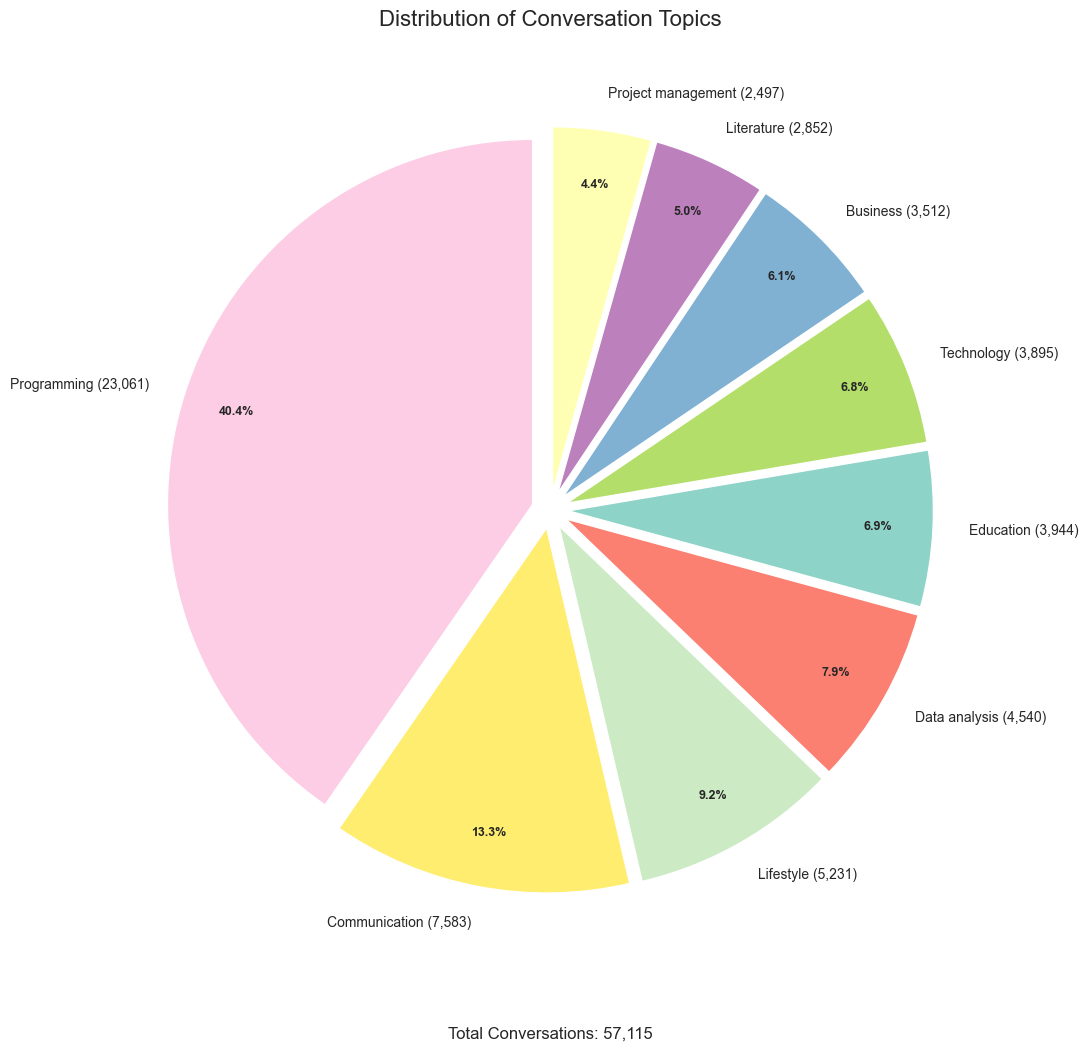

In [252]:
def create_color_mapping(merged_topic_info):
    distinct_colors = []
    n_colors = len(merged_topic_info)
    
    color_maps = [plt.cm.Set3, plt.cm.Paired, plt.cm.tab20, plt.cm.Set1]
    current_map_idx = 0
    colors_needed = n_colors
    
    while colors_needed > 0:
        current_map = color_maps[current_map_idx]
        n_colors_in_map = min(colors_needed, current_map.N)
        distinct_colors.extend(current_map(np.linspace(0, 1, n_colors_in_map)))
        colors_needed -= n_colors_in_map
        current_map_idx = (current_map_idx + 1) % len(color_maps)
    
    return dict(zip(merged_topic_info['label'], distinct_colors[:len(merged_topic_info)]))

def plot_topic_pie(merged_topic_info, min_percentage=2, color_mapping=None):
    total_docs = merged_topic_info['topic_size'].sum()
    merged_topic_info['percentage'] = merged_topic_info['topic_size'] / total_docs * 100
    
    main_topics = merged_topic_info[merged_topic_info['percentage'] >= min_percentage]
    small_topics = merged_topic_info[merged_topic_info['percentage'] < min_percentage]
    
    if not small_topics.empty:
        other_size = small_topics['topic_size'].sum()
        other_percentage = small_topics['percentage'].sum()
        plot_data = pd.concat([
            main_topics,
            pd.DataFrame({
                'label': ['Other'],
                'topic_size': [other_size],
                'percentage': [other_percentage],
                'topic': [-1]
            })
        ])
    else:
        plot_data = main_topics
    
    plot_data = plot_data.sort_values('topic_size', ascending=False)
    
    colors = [color_mapping[label] for label in plot_data['label']]
    
    plt.figure(figsize=(15, 10))
    wedges, texts, autotexts = plt.pie(
        plot_data['topic_size'],
        labels=[f"{label.capitalize()} ({size:,})" for label, size in zip(plot_data['label'], plot_data['topic_size'])],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        pctdistance=0.85,
        explode=[0.05] * len(plot_data)
    )
    
    plt.setp(autotexts, size=9, weight='bold')
    plt.setp(texts, size=10)
    plt.title('Distribution of Conversation Topics', fontsize=16, pad=20)
    plt.figtext(0.5, -0.05, f"Total Conversations: {total_docs:,}", ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

color_mapping = create_color_mapping(topic_info_labeled)
plot_topic_pie(topic_info_labeled, min_percentage=1, color_mapping=color_mapping)

In [254]:
def get_avg_message_length(post_number, df_expanded):
    conversation = df_expanded[df_expanded['post_number'] == post_number]
    return np.mean([len(str(msg)) for msg in conversation['message']])

topic_avg_lengths = fast_topic_df.groupby('topic').agg({
    'post_number': lambda x: np.mean([get_avg_message_length(pn, df_expanded) for pn in x])
}).reset_index()
topic_avg_lengths = topic_avg_lengths.merge(topic_info_labeled[['topic', 'label']], on='topic', how='left')
topic_avg_lengths = topic_avg_lengths.sort_values('post_number', ascending=True)

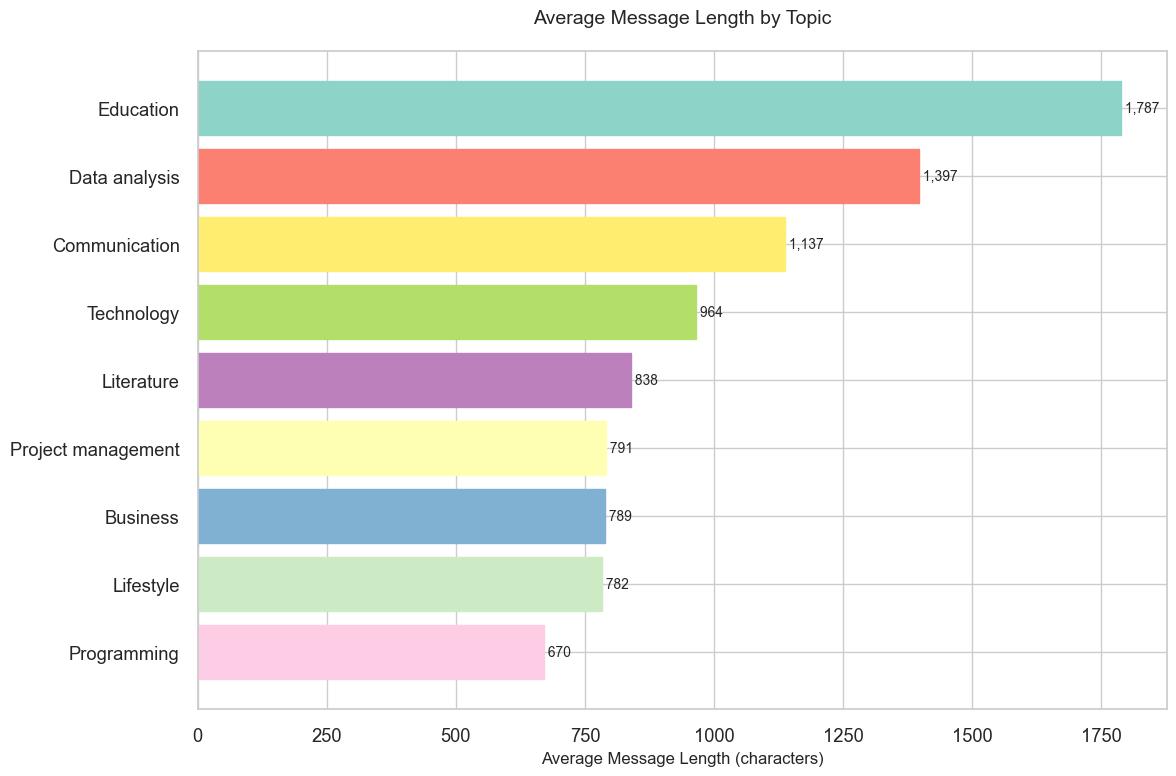

In [255]:
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(topic_avg_lengths)), topic_avg_lengths['post_number'])

for i, bar in enumerate(bars):
    bar.set_color(color_mapping[topic_avg_lengths['label'].iloc[i]])
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
            f' {int(width):,}',
            va='center', fontsize=10)

plt.xlabel('Average Message Length (characters)', fontsize=12)
plt.title('Average Message Length by Topic', fontsize=14, pad=20)

labels = [f"{label.capitalize()}" for label in topic_avg_lengths['label']]
plt.yticks(range(len(topic_avg_lengths)), labels)

plt.tight_layout()
plt.show()

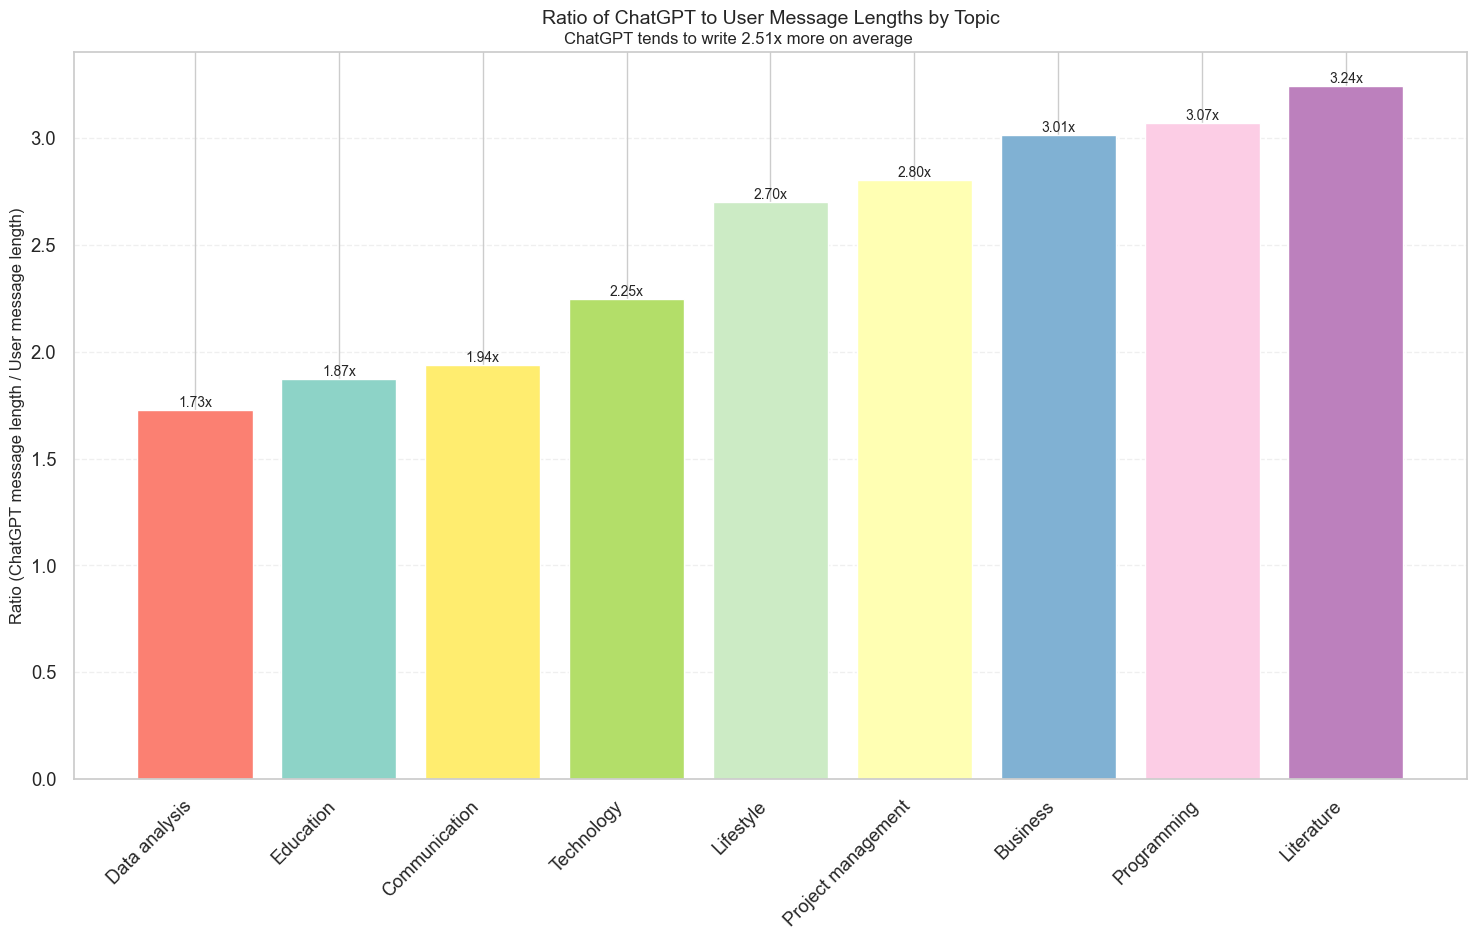

In [256]:
topic_df['ratio'] = topic_df['gpt_avg'] / topic_df['user_avg']
topic_df = topic_df.sort_values('ratio', ascending=True)

overall_ratio = topic_df['ratio'].mean()

plt.figure(figsize=(15, 10))

bars = plt.bar(range(len(topic_df)), topic_df['ratio'], 
               color=[color_mapping[label] for label in topic_df['label']])

plt.ylabel('Ratio (ChatGPT message length / User message length)', fontsize=12)
plt.title('Ratio of ChatGPT to User Message Lengths by Topic', fontsize=14, pad=20)
plt.suptitle(f"ChatGPT tends to write {overall_ratio:.2f}x more on average", fontsize=12, y=0.92)

labels = [f"{label.capitalize()}" 
          for label in topic_df['label']]
plt.xticks(range(len(topic_df)), labels, rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}x', 
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

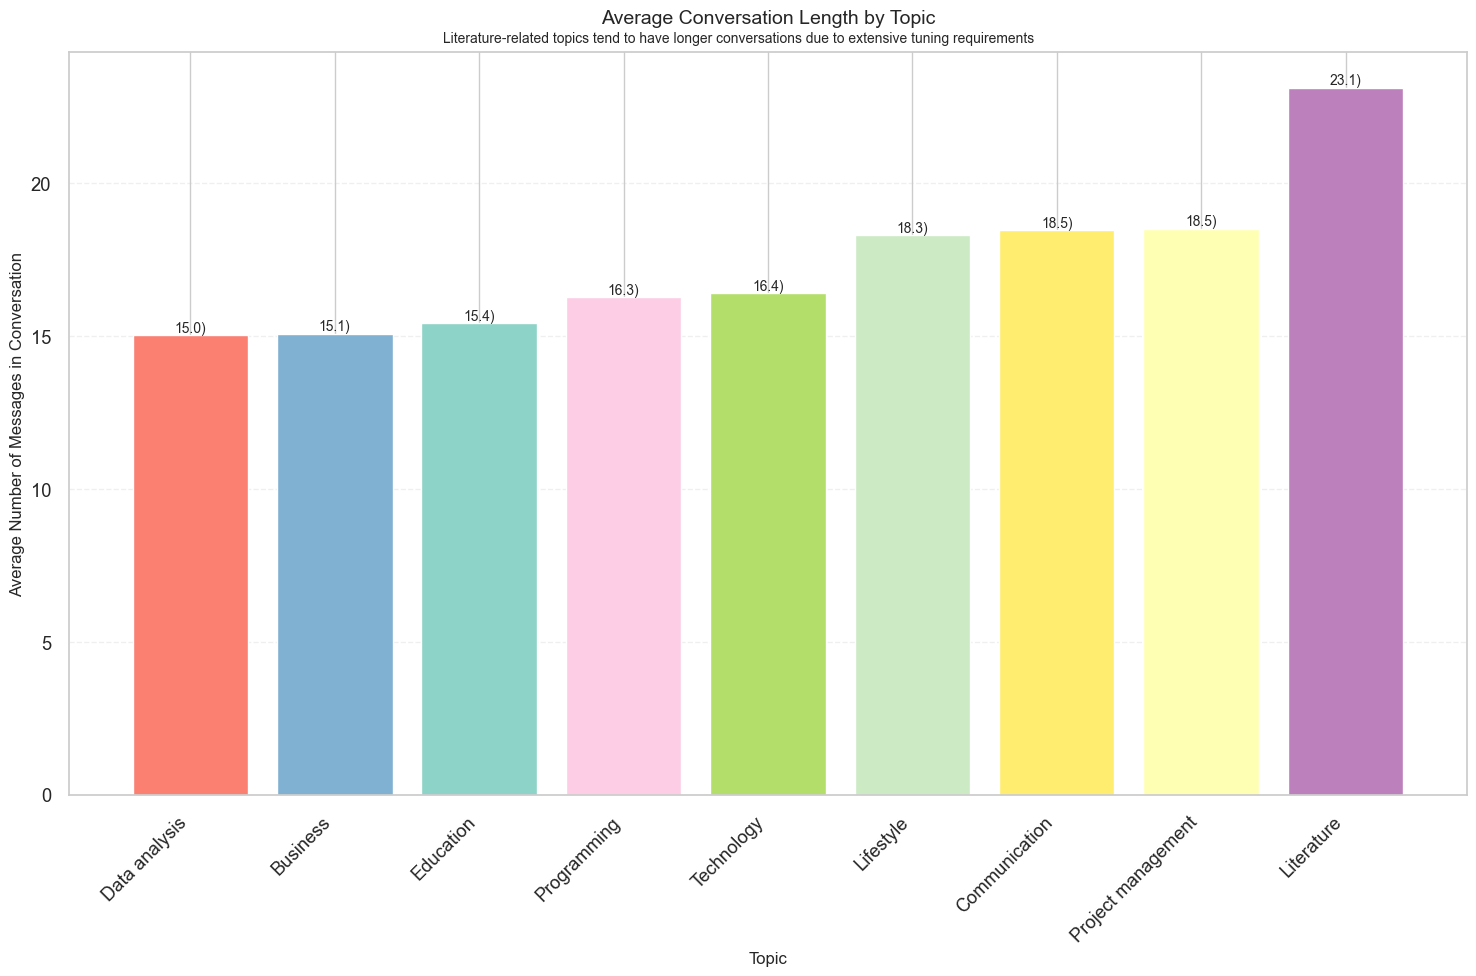

In [262]:
conversation_lengths = df_expanded.groupby('post_number').size().to_dict()
topic_sizes = fast_topic_df['topic'].value_counts().to_dict()
topic_stats = {}
for topic in fast_topic_df['topic'].unique():
    topic_posts = fast_topic_df[fast_topic_df['topic'] == topic]['post_number']
    lengths = [conversation_lengths.get(post, 0) for post in topic_posts]
    topic_stats[topic] = {
        'mean_length': np.mean(lengths),
        'count': topic_sizes[topic]
    }

plot_data = pd.DataFrame.from_dict(topic_stats, orient='index')
plot_data = plot_data.reset_index().rename(columns={'index': 'topic'})
plot_data = plot_data.merge(topic_info_labeled[['topic', 'label']], on='topic', how='left')
plot_data = plot_data.sort_values('mean_length', ascending=True)

plt.figure(figsize=(15, 10))

bars = plt.bar(range(len(plot_data)), 
               plot_data['mean_length'],
               color=[color_mapping[label] for label in plot_data['label']])

plt.title('Average Conversation Length by Topic\n', fontsize=14)
plt.figtext(0.5, 0.945, "Literature-related topics tend to have longer conversations due to extensive tuning requirements",
            fontsize=10, ha='center')
plt.ylabel('Average Number of Messages in Conversation', fontsize=12)
plt.xlabel('Topic', fontsize=12)

labels = [f"{label.capitalize()}" 
          for label in plot_data['label']]

plt.xticks(range(len(plot_data)), labels, rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, 
             f'{height:.1f})', 
             ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### User Feedback on ChatGPT Responses

Checking how accurate ChatGPT was back then (GPT-3.5, GPT-3.5-Turbo, and a bit of GPT-4) by analyzing how many users asked for corrections.

I'm using again `gpt-4o-mini` to analyze this by giving to it previous chat gpt message, next user message, and asking it to classify whether the user asked for a correction or if they were just continuing the conversation.

_Note: 1% of the messages were feeded to the `gpt-4o-mini` model for analysis._


In [308]:
from pydantic import BaseModel, Field
import json
from typing import Dict, Literal

class CorrectionAnalysis(BaseModel):
    results: Dict[str, Literal["fix", "continue", "unclear"]] = Field(
        description="Dictionary mapping message indices to correction request types"
    )
    
    model_config = {
        "json_schema_extra": {
            "examples": [{
                "results": {
                    "0": "fix",
                    "1": "continue", 
                    "2": "unclear"
                }
            }]
        }
    }

CORRECTION_PROMPT = """You are analyzing whether users are asking ChatGPT to fix/correct its previous response. Evaluate each pair of messages and return your analysis in JSON format.

Rules for analysis:
1. Assess if the user is asking for a correction, clarification, or pointing out errors
2. Look for indicators like "that's wrong", "can you fix", "not what I meant", etc.
3. If unclear or the user is just continuing the conversation, mark accordingly

Categories:
- "fix" = User is asking for corrections or pointing out errors
- "continue" = User is continuing the conversation without requesting fixes
- "unclear" = Cannot determine the intent clearly

Input format:
[0] ChatGPT: <previous response>
    User: <next message>
[1] ChatGPT: <previous response>
    User: <next message>
...and so on

Required output format:
{
    "results": {
        "0": "fix|continue|unclear",
        "1": "fix|continue|unclear",
        ...
    }
}

Example input:
[0] ChatGPT: Here's how to solve x + 2 = 5...
    User: That's not correct, x should be 3 not 7

[1] ChatGPT: Python is a programming language...
    User: Great, can you show me some examples?

Example output:
{
    "results": {
        "0": "fix",
        "1": "continue"
    }
}"""

def analyze_correction_requests(
    df_expanded,
    output_path='data/correction_analysis.csv',
    batch_size=50,
    max_workers=4,
    sample_size=-1
) -> pd.DataFrame:
    if Path(output_path).exists():
        print("Loading cached correction analysis results...")
        return pd.read_csv(output_path)

    df_temp = df_expanded.copy()
    df_temp['prev_user'] = df_temp.groupby('post_number')['user'].shift(1)
    df_temp['prev_message'] = df_temp.groupby('post_number')['message'].shift(1)
    
    message_pairs = df_temp[
        (df_temp['user'] == 'Anonymous') & 
        (df_temp['prev_user'] == 'Chat GPT')
    ].copy()
    
    if sample_size != -1:
        message_pairs = message_pairs.sample(
            n=min(sample_size, len(message_pairs)), 
            random_state=42
        ).sort_index()
    
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    def process_batch(pairs):
        try:
            formatted_pairs = "\n".join(
                f"[{i}] ChatGPT: {row.prev_message[:200]}\n    User: {row.message[:200]}"
                for i, row in enumerate(pairs.itertuples())
            )
            
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": CORRECTION_PROMPT
                    },
                    {
                        "role": "user",
                        "content": formatted_pairs
                    }
                ],
                response_format={"type": "json_object"},
                temperature=0.1
            )
            
            result = json.loads(response.choices[0].message.content)
            return list(CorrectionAnalysis(**result).results.values())
        except Exception as e:
            print(f"Error processing batch: {e}")
            return ["unclear"] * len(pairs)

    batch_indices = list(range(0, len(message_pairs), batch_size))
    message_batches = [
        (i, message_pairs.iloc[i:i + batch_size])
        for i in batch_indices
    ]
    
    results = [None] * len(message_pairs)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx
            for idx, batch in message_batches
        }
        
        for future in tqdm(
            as_completed(futures), 
            total=len(futures), 
            desc="Analyzing correction requests",
            ncols=100
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx:idx + batch_length] = batch_results
    
    correction_df = pd.DataFrame({
        'post_number': message_pairs['post_number'].values,
        'message_order': message_pairs['message_order'].values,
        'chatgpt_message': message_pairs['prev_message'].values,
        'user_message': message_pairs['message'].values,
        'correction_type': results
    })
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    correction_df.to_csv(output_path, index=False)
    
    return correction_df

correction_results = analyze_correction_requests(
    df_expanded,
    sample_size=10000,
    batch_size=20,
)

Analyzing correction requests: 100%|██████████████████████████████| 500/500 [06:47<00:00,  1.23it/s]


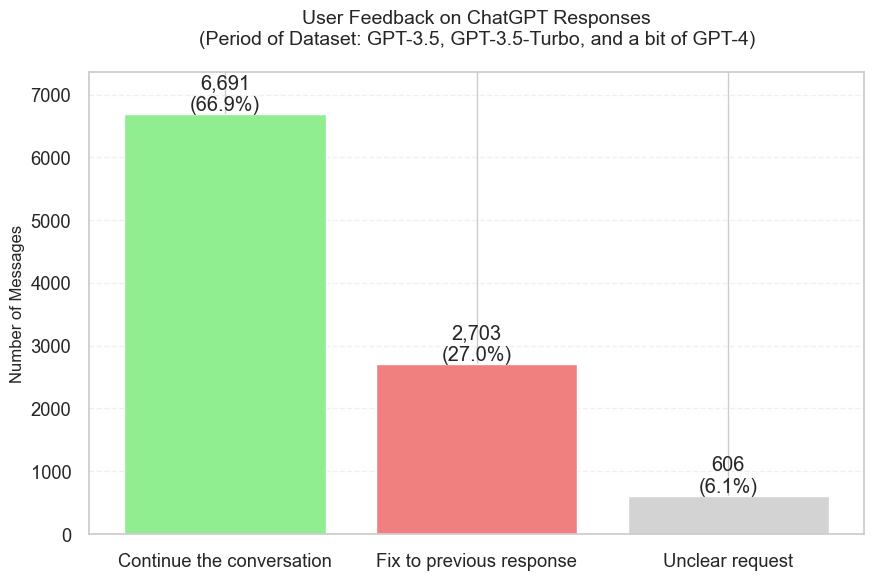

In [316]:
correction_counts = correction_results['correction_type'].value_counts()
labels = ['Continue the conversation', 'Fix to previous response', 'Unclear request']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, correction_counts.values, color=['lightgreen', 'lightcoral', 'lightgray'])

plt.title('User Feedback on ChatGPT Responses\n(Period of Dataset: GPT-3.5, GPT-3.5-Turbo, and a bit of GPT-4)', fontsize=14, pad=20)
plt.ylabel('Number of Messages', fontsize=12)

plt.ylim(0, correction_counts.max() * 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{int(height):,}\n({height/len(correction_results)*100:.1f}%)',
             ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [315]:
print("\nExamples of correction requests:")
correction_examples = correction_results[correction_results['correction_type'] == 'fix'].head()
for _, row in correction_examples.iterrows():
    print("\nChatGPT:", row['chatgpt_message'][:100], "...")
    print("User:", row['user_message'][:100], "...")


Examples of correction requests:

ChatGPT: Here is a complete C++ implementation for FizzBuzz: This program uses a for loop to iterate from 1 t ...
User: Great, now change the code so that the iteration length is provided by the user through stdin. ...

ChatGPT: Here is a modified version of the FizzBuzz program that checks for a valid iteration length and exit ...
User: Instead of checking for "*endptr != '\0'", wouldn't it be enough to just check for "endptr != &argv[ ...

ChatGPT: The name of the school that Harmony Hearts attend is not specified in the previous story. It would b ...
User: suggest a name of their school ...

ChatGPT: I apologize for the misunderstanding. Here is a revised syllabus that focuses more on the intellectu ...
User: I think Week 6 - 8 could be more rigorous, more esoteric, and more theoretical, while exploring expl ...

ChatGPT: It is not possible for me to combine all the best elements of each theory and form a new one, as it  ...
User: provide a theoret

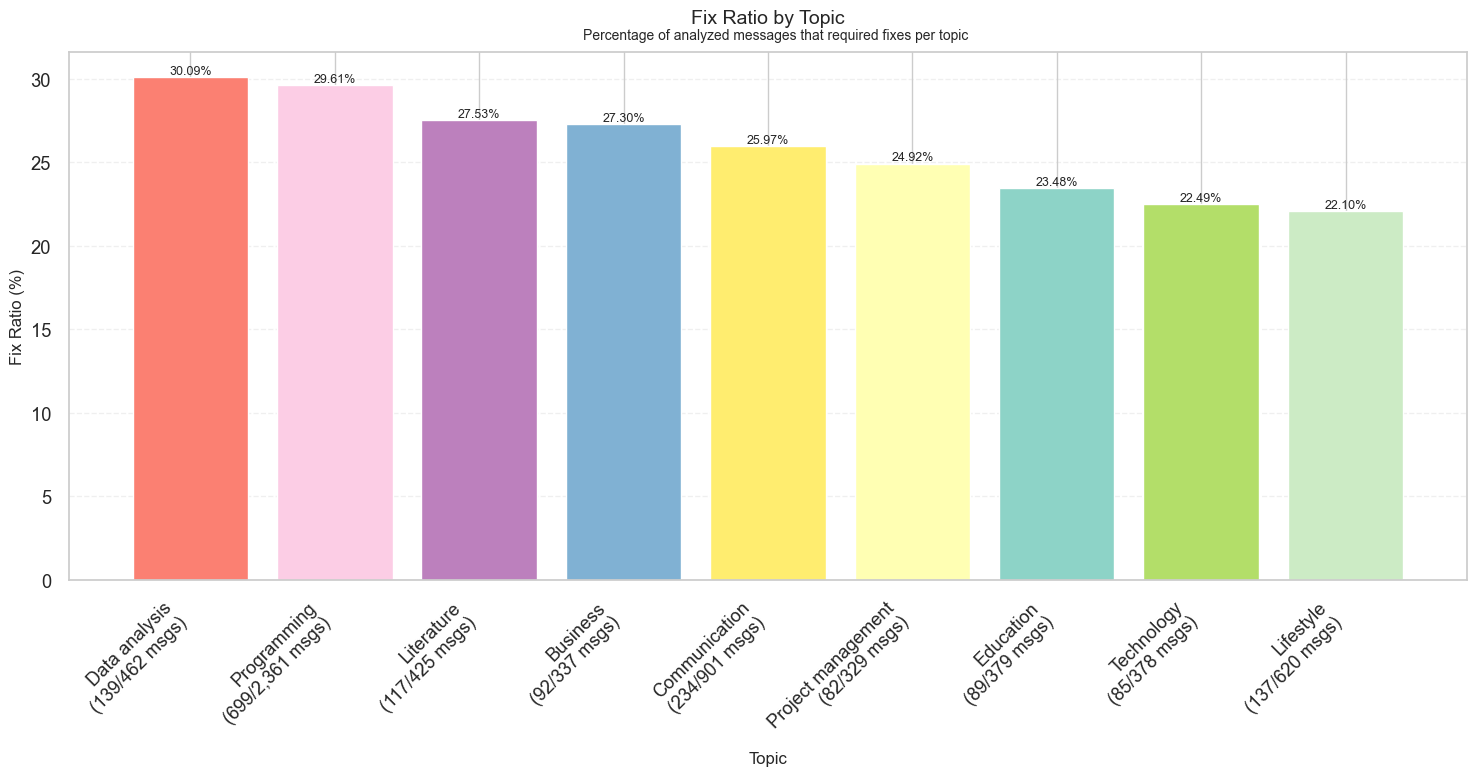

In [326]:
topic_fixes = {}
for topic in fast_topic_df['topic'].unique():
    topic_posts = set(fast_topic_df[fast_topic_df['topic'] == topic]['post_number'])
    topic_corrections = correction_results[correction_results['post_number'].isin(topic_posts)]
    
    fixes = len(topic_corrections[topic_corrections['correction_type'] == 'fix'])
    total_analyzed = len(topic_corrections)
    
    topic_fixes[topic] = {
        'fixes': fixes,
        'total_analyzed': total_analyzed,
        'fix_ratio': fixes / total_analyzed if total_analyzed > 0 else 0
    }

fix_ratio_df = pd.DataFrame.from_dict(topic_fixes, orient='index').reset_index()
fix_ratio_df.columns = ['topic', 'fixes', 'total_analyzed', 'fix_ratio']
fix_ratio_df = fix_ratio_df.merge(topic_info_labeled[['topic', 'label']], on='topic', how='left')
fix_ratio_df = fix_ratio_df.sort_values('fix_ratio', ascending=False)

plt.figure(figsize=(15, 8))

bars = plt.bar(range(len(fix_ratio_df)), 
               fix_ratio_df['fix_ratio'] * 100,
               color=[color_mapping[label] for label in fix_ratio_df['label']])

plt.title('Fix Ratio by Topic\n', fontsize=14)
plt.figtext(0.525, 0.935, "Percentage of analyzed messages that required fixes per topic",
            fontsize=10, ha='center')
plt.ylabel('Fix Ratio (%)', fontsize=12)
plt.xlabel('Topic', fontsize=12)

labels = [f"{label.capitalize()}\n({fixes:,}/{total:,} msgs)" 
          for label, fixes, total in zip(fix_ratio_df['label'], 
                                       fix_ratio_df['fixes'], 
                                       fix_ratio_df['total_analyzed'])]

plt.xticks(range(len(fix_ratio_df)), labels, rotation=45, ha='right')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Prompt techniques users use

The analysis was performed using the `gpt-4o-mini` model.
The following prompt techniques were provided for classification:

- **Zero-shot**: Direct task without examples (e.g., "Translate 'Good morning' into Spanish.")
- **One-shot**: One example before the task (e.g., "Translate 'Hello' into Spanish: 'Hola'. Now, translate 'Good morning' into Spanish.")
- **Few-shot**: Multiple examples before the task (e.g., 
  "Translate the following into Spanish:
  - 'Hello': 'Hola'
  - 'Thank you': 'Gracias'
  - 'Good morning': 'Buenos días'")

- **Chain-of-thought**: Breaking down complex problems step by step (e.g., "Solve this problem step by step: If you have 5 apples and you buy 3 more, how many apples do you have in total?")
- **Role**: Assigning specific role/persona (e.g., "You are an experienced doctor. Explain the importance of a balanced diet.")
- **Instruction**: Clear, specific task instructions (e.g., "List three benefits of regular exercise in bullet points.")
- **Format**: Specifying output structure (e.g., "Provide a summary of the article in no more than 100 words.")
- **Contextual**: Including background information (e.g., "Considering the economic impacts of the 2008 financial crisis, discuss its effect on small businesses.")
- **Negative**: Specifying what to avoid (e.g., "Explain photosynthesis without using scientific jargon.")
- **Socratic**: Series of questions for deeper understanding (e.g., "What is renewable energy? Why is it important? How can it benefit the environment?")


In [339]:
from pydantic import BaseModel, Field
from typing import List
from openai import RateLimitError
from time import sleep

class PromptAnalysis(BaseModel):
    results: Dict[str, List[str]] = Field(
        description="Dictionary mapping message indices to lists of prompt techniques"
    )
    
    model_config = {
        "json_schema_extra": {
            "examples": [{
                "results": {
                    "0": ["zero-shot", "instruction"],
                    "1": ["role", "format"]
                }
            }]
        }
    }

PROMPT_TECHNIQUES_PROMPT = """Analyze which prompt techniques are used in each message. Return your analysis in JSON format.

Available prompt techniques:
- zero-shot: Direct task without examples (e.g., "Translate 'hello' to Spanish")
- one-shot: One example before the task
- few-shot: Multiple examples before the task
- chain-of-thought: Breaking down complex problems step by step
- role: Assigning specific role/persona
- instruction: Clear, specific task instructions
- format: Specifying output structure
- contextual: Including background information
- negative: Specifying what to avoid
- socratic: Series of questions for deeper understanding

Rules:
1. Each message can use multiple techniques
2. Focus on identifying clear indicators of each technique
3. If no clear technique is used, return an empty array
4. Consider the entire message context

Input format:
[0] User message 1
[1] User message 2
...

Required output format:
{
    "results": {
        "0": ["technique1", "technique2"],
        "1": ["technique3"],
        ...
    }
}

Example input:
[0] You are a math teacher. Explain multiplication step by step for a 7-year-old.
[1] Translate 'hello' to Spanish. Example: 'good' -> 'bueno'

Example output:
{
    "results": {
        "0": ["role", "instruction", "chain-of-thought"],
        "1": ["one-shot"]
    }
}"""

def analyze_prompt_techniques(
    df_expanded,
    output_path='data/prompt_techniques_analysis.csv',
    batch_size=50,
    max_workers=2,
    sample_size=-1
) -> pd.DataFrame:    
    if Path(output_path).exists():
        print("Loading cached prompt techniques analysis results...")
        return pd.read_csv(output_path)

    first_messages = df_expanded[
        (df_expanded['message_order'] == 0) & 
        (df_expanded['user'] == 'Anonymous')
    ].copy()
    
    if sample_size != -1:
        first_messages = first_messages.sample(
            n=min(sample_size, len(first_messages)), 
            random_state=42
        ).sort_index()
    
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    def process_batch(messages):
        max_retries = 3
        attempt = 0
        while attempt < max_retries:
            try:
                formatted_messages = "\n".join(
                f"[{i}] {msg}" 
                for i, msg in enumerate(messages['message'])
                )
            
                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                    {
                        "role": "system",
                        "content": PROMPT_TECHNIQUES_PROMPT
                    },
                    {
                        "role": "user",
                        "content": formatted_messages
                    }
                ],
                response_format={"type": "json_object"},
                    temperature=0.1
                )
            
                result = json.loads(response.choices[0].message.content)
                return list(PromptAnalysis(**result).results.values())
            except RateLimitError:
                if attempt < max_retries - 1:
                    print(f"\nRate limit hit, waiting 60 seconds... (attempt {attempt + 1}/{max_retries})")
                    sleep(60)
                    attempt += 1
                    continue
            except Exception as e:
                print(f"Error processing batch: {e}")
                return [[] for _ in range(len(messages))]

    batch_indices = list(range(0, len(first_messages), batch_size))
    message_batches = [
        (i, first_messages.iloc[i:i + batch_size])
        for i in batch_indices
    ]
    
    results = [None] * len(first_messages)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx
            for idx, batch in message_batches
        }
        
        for future in tqdm(
            as_completed(futures), 
            total=len(futures), 
            desc="Analyzing prompt techniques",
            ncols=100
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx:idx + batch_length] = batch_results
    
    techniques_df = pd.DataFrame({
        'post_number': first_messages['post_number'].values,
        'message': first_messages['message'].values,
        'techniques': results
    })
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    techniques_df.to_csv(output_path, index=False)
    
    return techniques_df

techniques_results = analyze_prompt_techniques(
    df_expanded,
    sample_size=10000,
    batch_size=10,
)

Analyzing prompt techniques:  88%|███████████████████████████▏   | 875/1000 [14:29<03:49,  1.83s/it]


Rate limit hit, waiting 60 seconds... (attempt 1/3)


Analyzing prompt techniques:  89%|███████████████████████████▍   | 886/1000 [14:57<04:42,  2.48s/it]


Rate limit hit, waiting 60 seconds... (attempt 1/3)


Analyzing prompt techniques: 100%|██████████████████████████████| 1000/1000 [19:07<00:00,  1.15s/it]


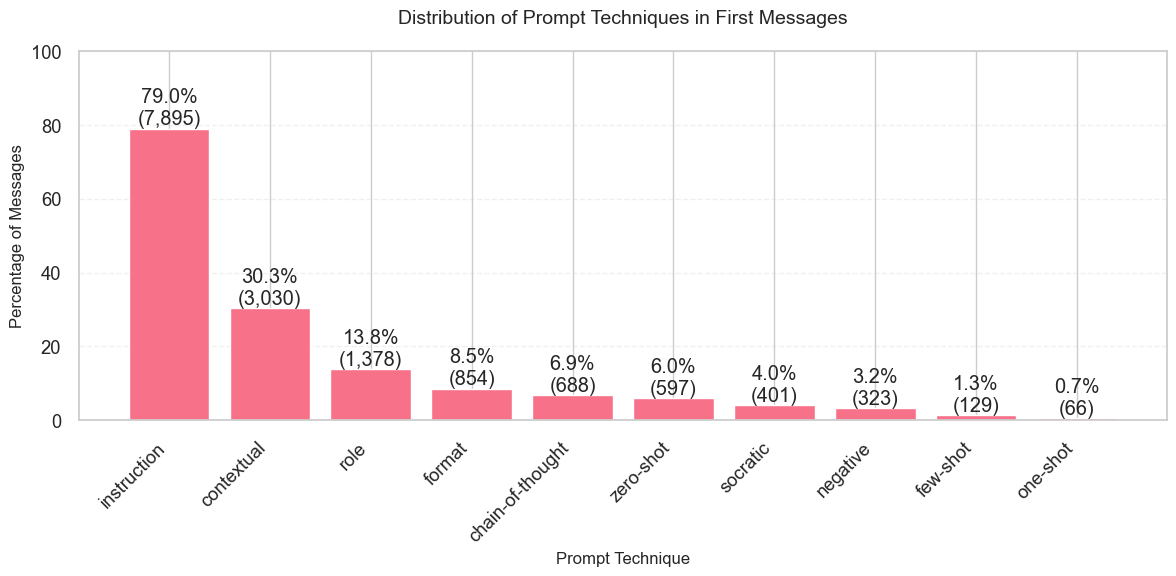

In [351]:
def plot_technique_distribution(techniques_df):
    valid_techniques = {
        'zero-shot', 'one-shot', 'few-shot', 'chain-of-thought', 
        'role', 'instruction', 'format', 'contextual', 'negative', 'socratic'
    }
    
    all_techniques = [
        technique 
        for techniques in techniques_df['techniques'] 
        if isinstance(techniques, list)
        for technique in techniques
        if technique in valid_techniques
    ]
    
    technique_counts = pd.Series(all_techniques).value_counts()
    total_messages = len(techniques_df)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        range(len(technique_counts)), 
        technique_counts.values / total_messages * 100
    )
    
    plt.title('Distribution of Prompt Techniques in First Messages', fontsize=14, pad=20)
    plt.ylabel('Percentage of Messages', fontsize=12)
    plt.xlabel('Prompt Technique', fontsize=12) 
    
    plt.xticks(
        range(len(technique_counts)), 
        technique_counts.index, 
        rotation=45, 
        ha='right'
    )
    
    for bar in bars:
        height = bar.get_height()
        count = int(height * total_messages / 100)
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            height,
            f'{height:.1f}%\n({count:,})',
            ha='center', 
            va='bottom'
        )
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_technique_distribution(techniques_results)

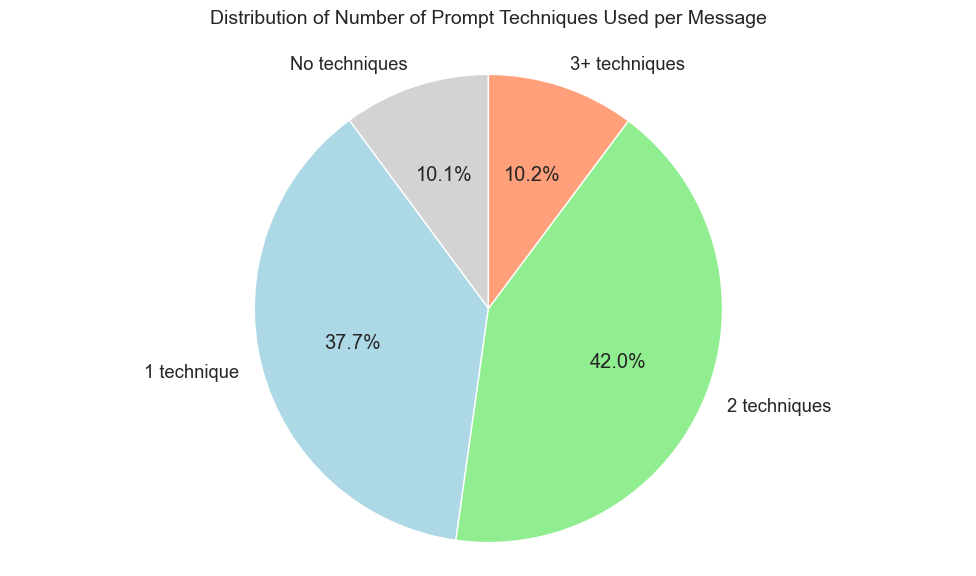

In [353]:
def plot_technique_count_distribution(techniques_df):
    technique_counts = techniques_df['techniques'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    count_categories = pd.cut(
        technique_counts,
        bins=[-float('inf'), 0, 1, 2, float('inf')],
        labels=['No techniques', '1 technique', '2 techniques', '3+ techniques']
    )
    
    count_distribution = count_categories.value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.pie(
        count_distribution.values,
        labels=count_distribution.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightgray', 'lightblue', 'lightgreen', 'lightsalmon']
    )
    
    plt.title('Distribution of Number of Prompt Techniques Used per Message', fontsize=14, pad=20)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

plot_technique_count_distribution(techniques_results)

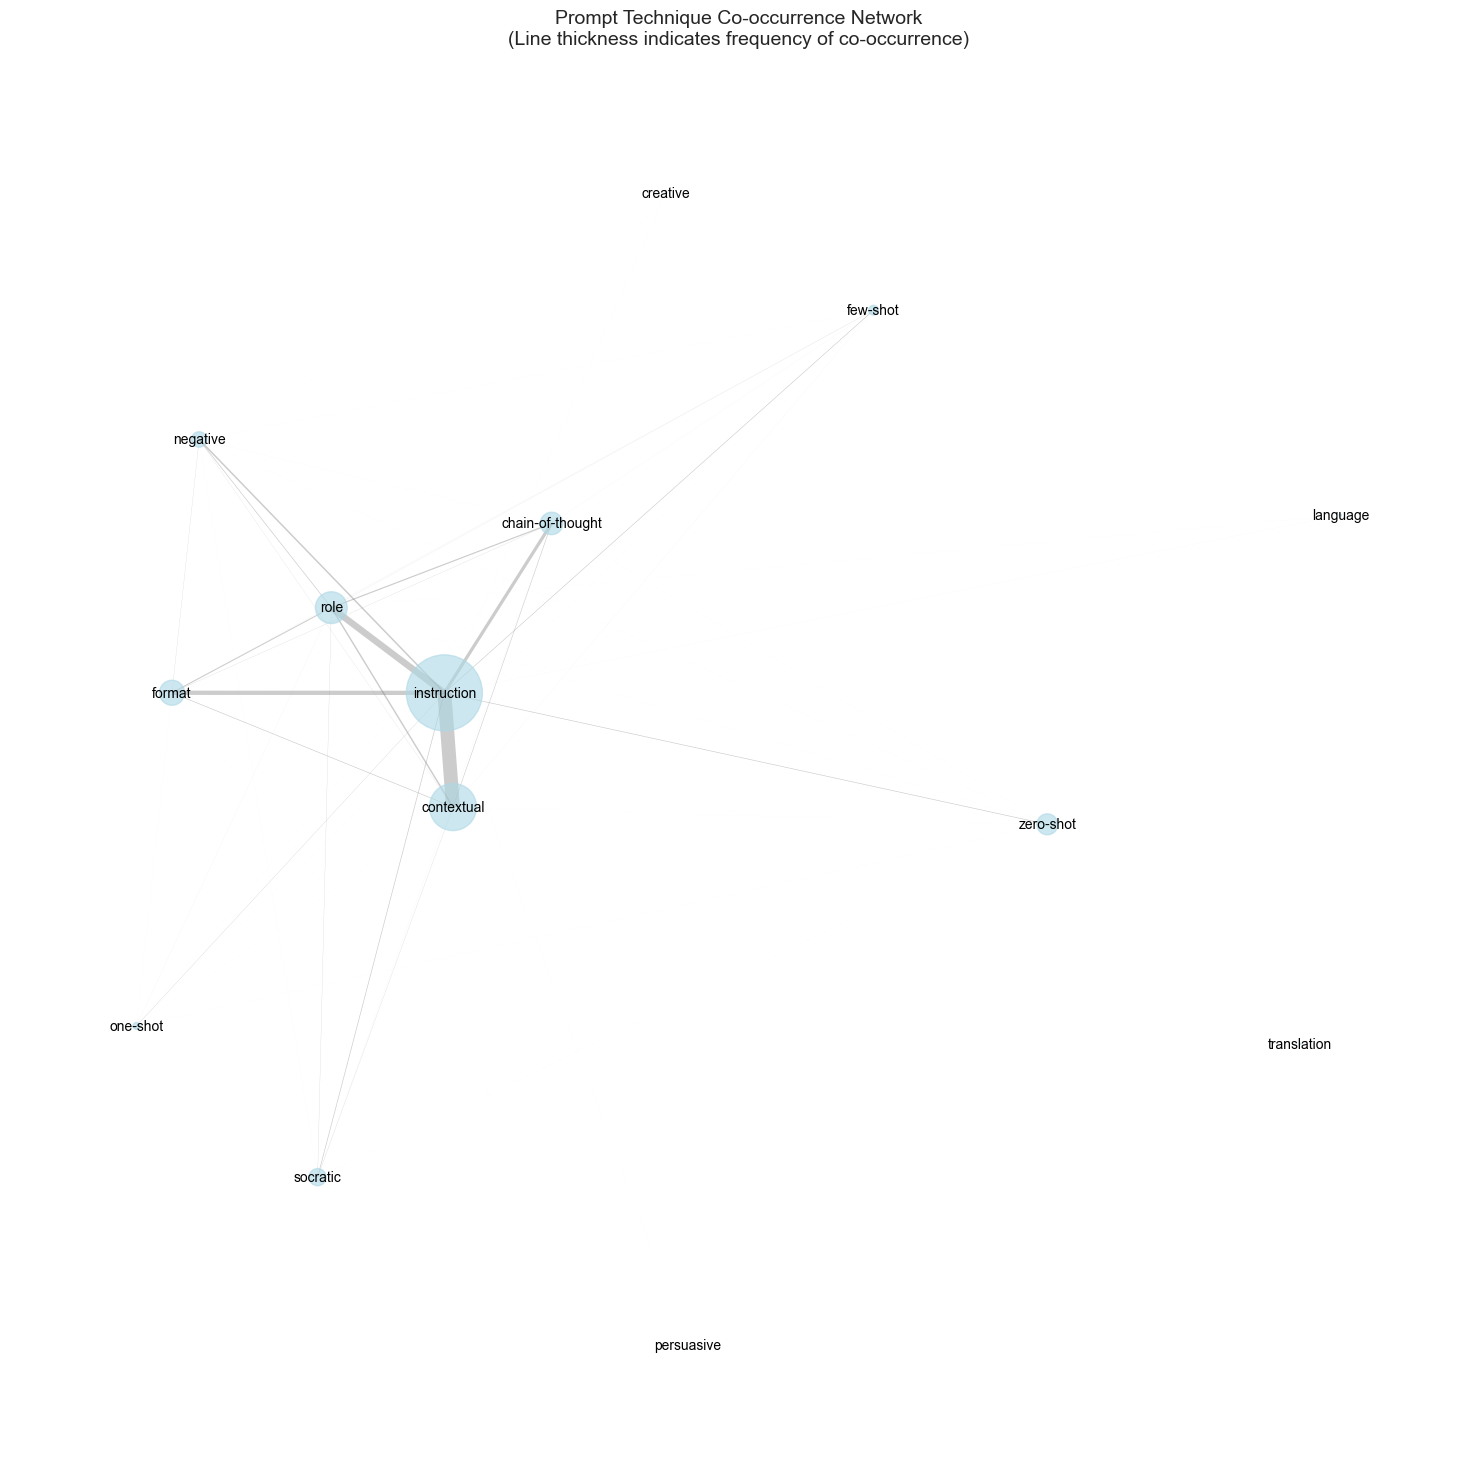


Most common technique pairs:
contextual + instruction: 2760 times
instruction + role: 1298 times
format + instruction: 852 times
chain-of-thought + instruction: 637 times
instruction + negative: 299 times


In [355]:
import networkx as nx

def create_technique_network(techniques_df):
    G = nx.Graph()
    co_occurrences = {}
    
    for techniques in techniques_df['techniques']:
        if not isinstance(techniques, list) or len(techniques) < 2:
            continue
            
        for i in range(len(techniques)):
            for j in range(i + 1, len(techniques)):
                pair = tuple(sorted([techniques[i], techniques[j]]))
                co_occurrences[pair] = co_occurrences.get(pair, 0) + 1
    
    max_weight = max(co_occurrences.values())
    for (tech1, tech2), weight in co_occurrences.items():
        normalized_weight = (weight / max_weight) * 10
        G.add_edge(tech1, tech2, weight=normalized_weight)
    
    node_sizes = {}
    for techniques in techniques_df['techniques']:
        if not isinstance(techniques, list):
            continue
        for tech in techniques:
            node_sizes[tech] = node_sizes.get(tech, 0) + 1
    
    plt.figure(figsize=(15, 15))
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    edges = G.edges(data=True)
    weights = [d['weight'] for (u, v, d) in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4, edge_color='gray')
    
    max_size = max(node_sizes.values())
    node_list = list(G.nodes())
    node_sizes_normalized = [node_sizes.get(node, 0) / max_size * 3000 for node in node_list]
    
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes_normalized,
                          node_color='lightblue',
                          alpha=0.6)
    
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title('Prompt Technique Co-occurrence Network\n(Line thickness indicates frequency of co-occurrence)', 
              fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("\nMost common technique pairs:")
    top_pairs = sorted(co_occurrences.items(), key=lambda x: x[1], reverse=True)[:5]
    for (tech1, tech2), count in top_pairs:
        print(f"{tech1} + {tech2}: {count} times")

create_technique_network(techniques_results)

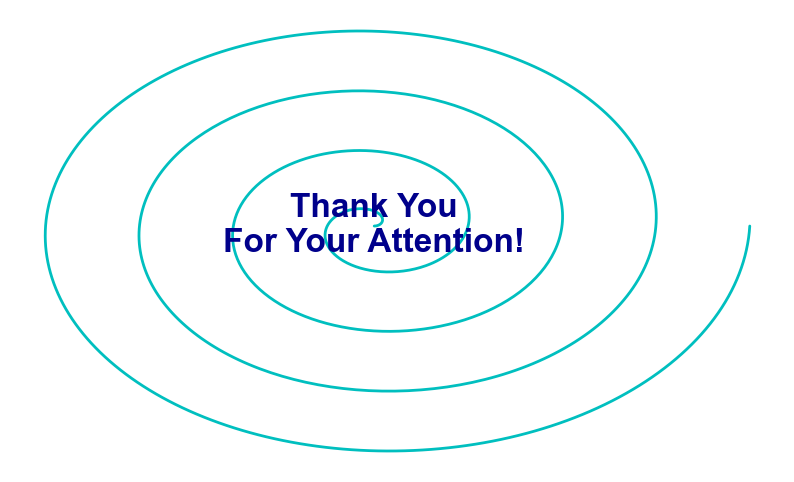

In [391]:
theta = np.linspace(0, 8 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color='c', linewidth=2)

ax.text(0, 0, 'Thank You\nFor Your Attention!', 
        fontsize=24, color='darkblue', fontweight='bold',
        ha='center', va='center')

ax.set_facecolor('lavender')
ax.axis('off')

plt.show()